### **Import Libraries**

In [2]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import warnings

### **Load dataset**

In [3]:
data = pd.read_csv("road-casualty-statistics-collision.csv", low_memory=False)
data.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2023010419171           2023          010419171               525060.0   
1  2023010419183           2023          010419183               535463.0   
2  2023010419189           2023          010419189               508702.0   
3  2023010419191           2023          010419191               520341.0   
4  2023010419192           2023          010419192               527255.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                170416.0  -0.202878  51.418974             1   
1                198745.0  -0.042464  51.671155             1   
2                177696.0  -0.435789  51.487777             1   
3                190175.0  -0.263972  51.597575             1   
4                176963.0  -0.168976  51.477324             1   

   accident_severity  number_of_vehicles  ...  light_conditions  \
0                  3                   1  ...                 4   
1                  3                   3  ...                 4   
2                  3                   2  ...                 4   
3                  3                   2  ...                 4   
4                  3                   2  ...                 4   

  weather_conditions  road_surface_conditions special_conditions_at_site  \
0                  8                        2                          0   
1                  1                        1                          0   
2                  1                        1                          0   
3                  9                        1                          0   
4                  1                        1                          0   

   carriageway_hazards urban_or_rural_area  \
0                    0                   1   
1                    0                   1   
2                    0                   1   
3                    0                   1   
4                    0                   1   

  did_police_officer_attend_scene_of_accident  trunk_road_flag  \
0                                           1                2   
1                                           1                2   
2                                           1                2   
3                                           1                2   
4                                           1                2   

   lsoa_of_accident_location  enhanced_severity_collision  
0                  E01003383                           -1  
1                  E01001547                           -1  
2                  E01002448                           -1  
3                  E01000129                           -1  
4                  E01004583                           -1  

[5 rows x 37 columns]

### **Breaking down the data**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104258 entries, 0 to 104257
Data columns (total 37 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               104258 non-null  object 
 1   accident_year                                104258 non-null  int64  
 2   accident_reference                           104258 non-null  object 
 3   location_easting_osgr                        104246 non-null  float64
 4   location_northing_osgr                       104246 non-null  float64
 5   longitude                                    104246 non-null  float64
 6   latitude                                     104246 non-null  float64
 7   police_force                                 104258 non-null  int64  
 8   accident_severity                            104258 non-null  int64  
 9   number_of_vehicles                           104258 non-nul

In [5]:
data.isnull().sum()

accident_index                                  0
accident_year                                   0
accident_reference                              0
location_easting_osgr                          12
location_northing_osgr                         12
longitude                                      12
latitude                                       12
police_force                                    0
accident_severity                               0
number_of_vehicles                              0
number_of_casualties                            0
date                                            0
day_of_week                                     0
time                                            0
local_authority_district                        0
local_authority_ons_district                    0
local_authority_highway                         0
first_road_class                                0
first_road_number                               0
road_type                                       0


Text(0.5, 1.0, 'Missing Values Heatmap')

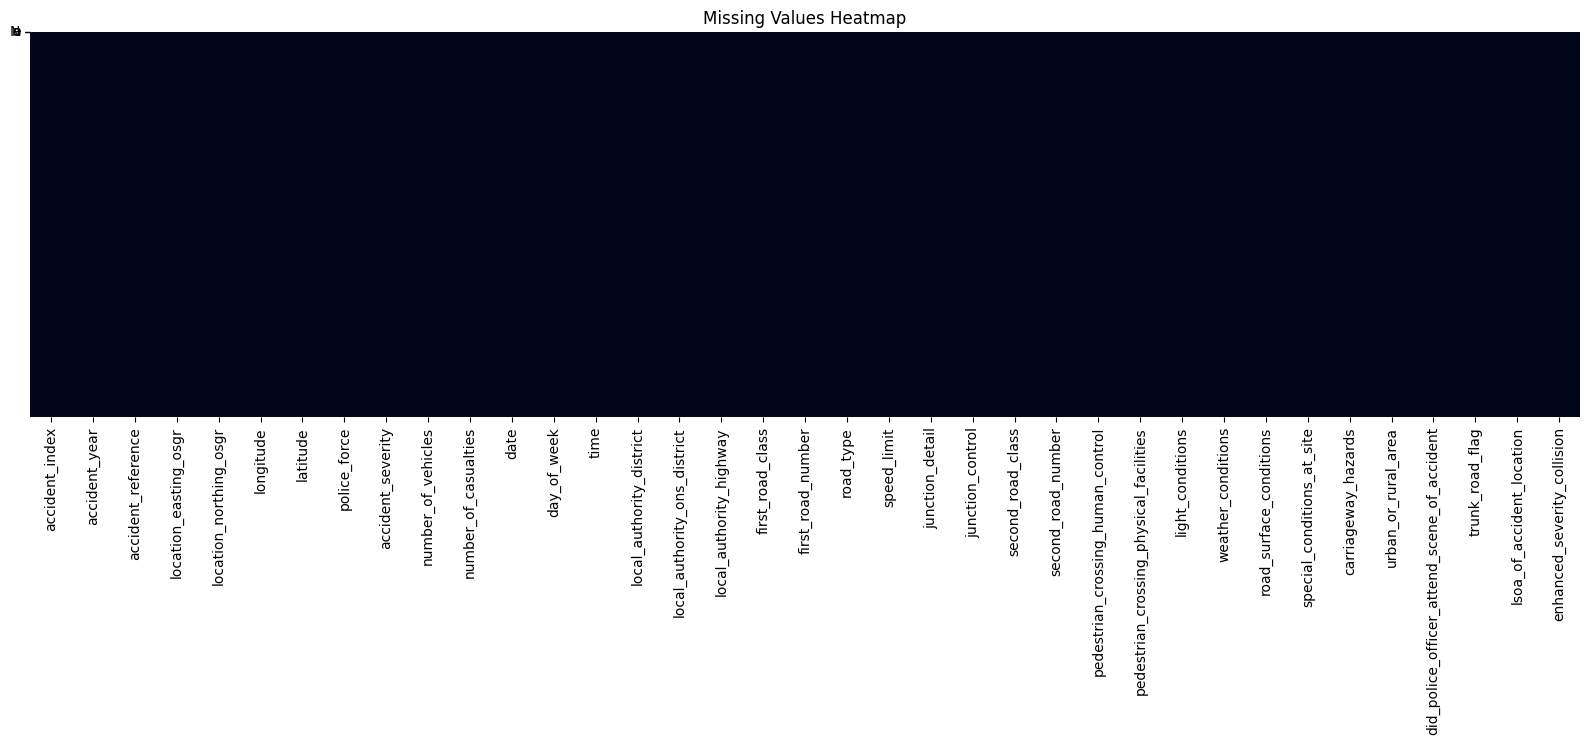

In [6]:
#missingness
plt.figure(figsize=(20,5))
sns.heatmap(data.isnull(), yticklabels="None", cbar=False)
plt.title("Missing Values Heatmap")


Missing Values Summary:
                        Missing_Count  Missing_Percentage
location_northing_osgr             12             0.01151
location_easting_osgr              12             0.01151
longitude                          12             0.01151
latitude                           12             0.01151


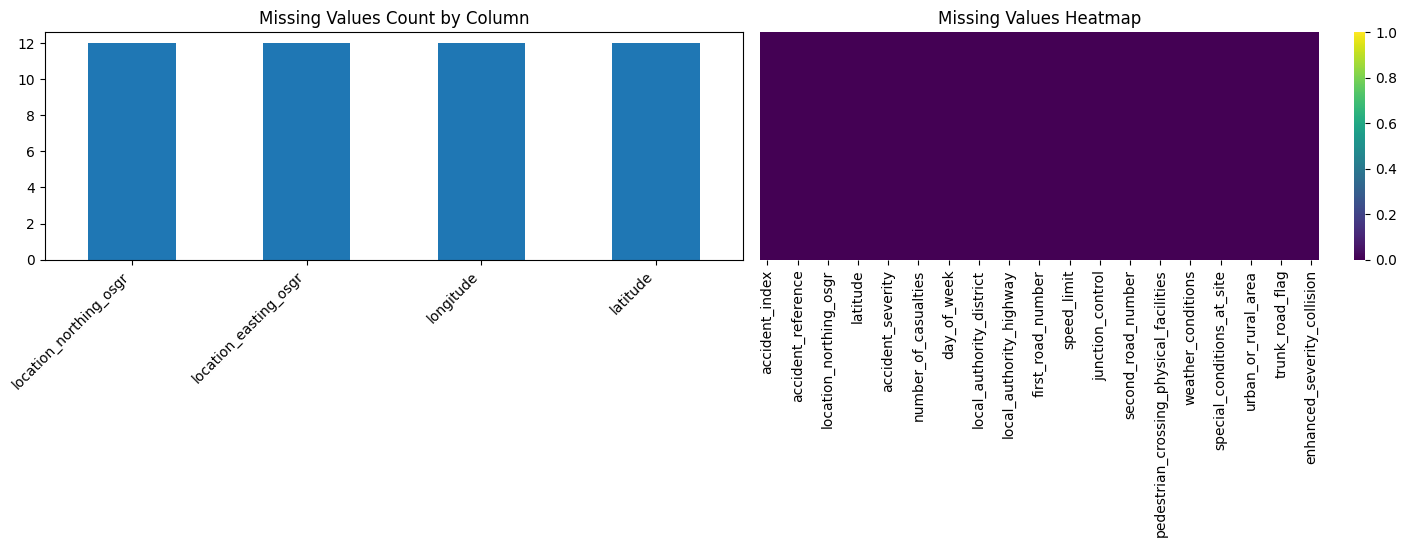

In [7]:
missing_data = data.isnull().sum()
missing_percent = (missing_data / len(data)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)

print("\nMissing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Visualize missing values
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
missing_cols = missing_df[missing_df['Missing_Count'] > 0]
if not missing_cols.empty:
    missing_cols['Missing_Count'].plot(kind='bar')
    plt.title('Missing Values Count by Column')
    plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 2)
# Heatmap of missing values pattern
sns.heatmap(data.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')

plt.tight_layout()
plt.show()

In [8]:
# Separating the numerical variables from the categorical variables
cat_var=data.select_dtypes(include=[object])
num_var = data.select_dtypes(include=['float','int'])

print(f"Categorical:\n {cat_var.columns}")
print(f"Numerical:\n {num_var.columns}")

Categorical:
 Index(['accident_index', 'accident_reference', 'date', 'time',
       'local_authority_ons_district', 'local_authority_highway',
       'lsoa_of_accident_location'],
      dtype='object')
Numerical:
 Index(['accident_year', 'location_easting_osgr', 'location_northing_osgr',
       'longitude', 'latitude', 'police_force', 'accident_severity',
       'number_of_vehicles', 'number_of_casualties', 'day_of_week',
       'local_authority_district', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'enhanced_severity_collision'],
      dty

Numerical columns: ['accident_year', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force', 'number_of_vehicles', 'number_of_casualties', 'day_of_week', 'local_authority_district', 'first_road_class', 'first_road_number', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'second_road_class', 'second_road_number', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident', 'trunk_road_flag', 'enhanced_severity_collision']
Number of numerical features: 29

Descriptive Statistics for Numerical Features:
       accident_year  location_easting_osgr  location_northing_osgr  \
count       104258.0          104246.000000            1.042460e+05   
mean          2023.0          455388.583284            2.754993e+05   
std            

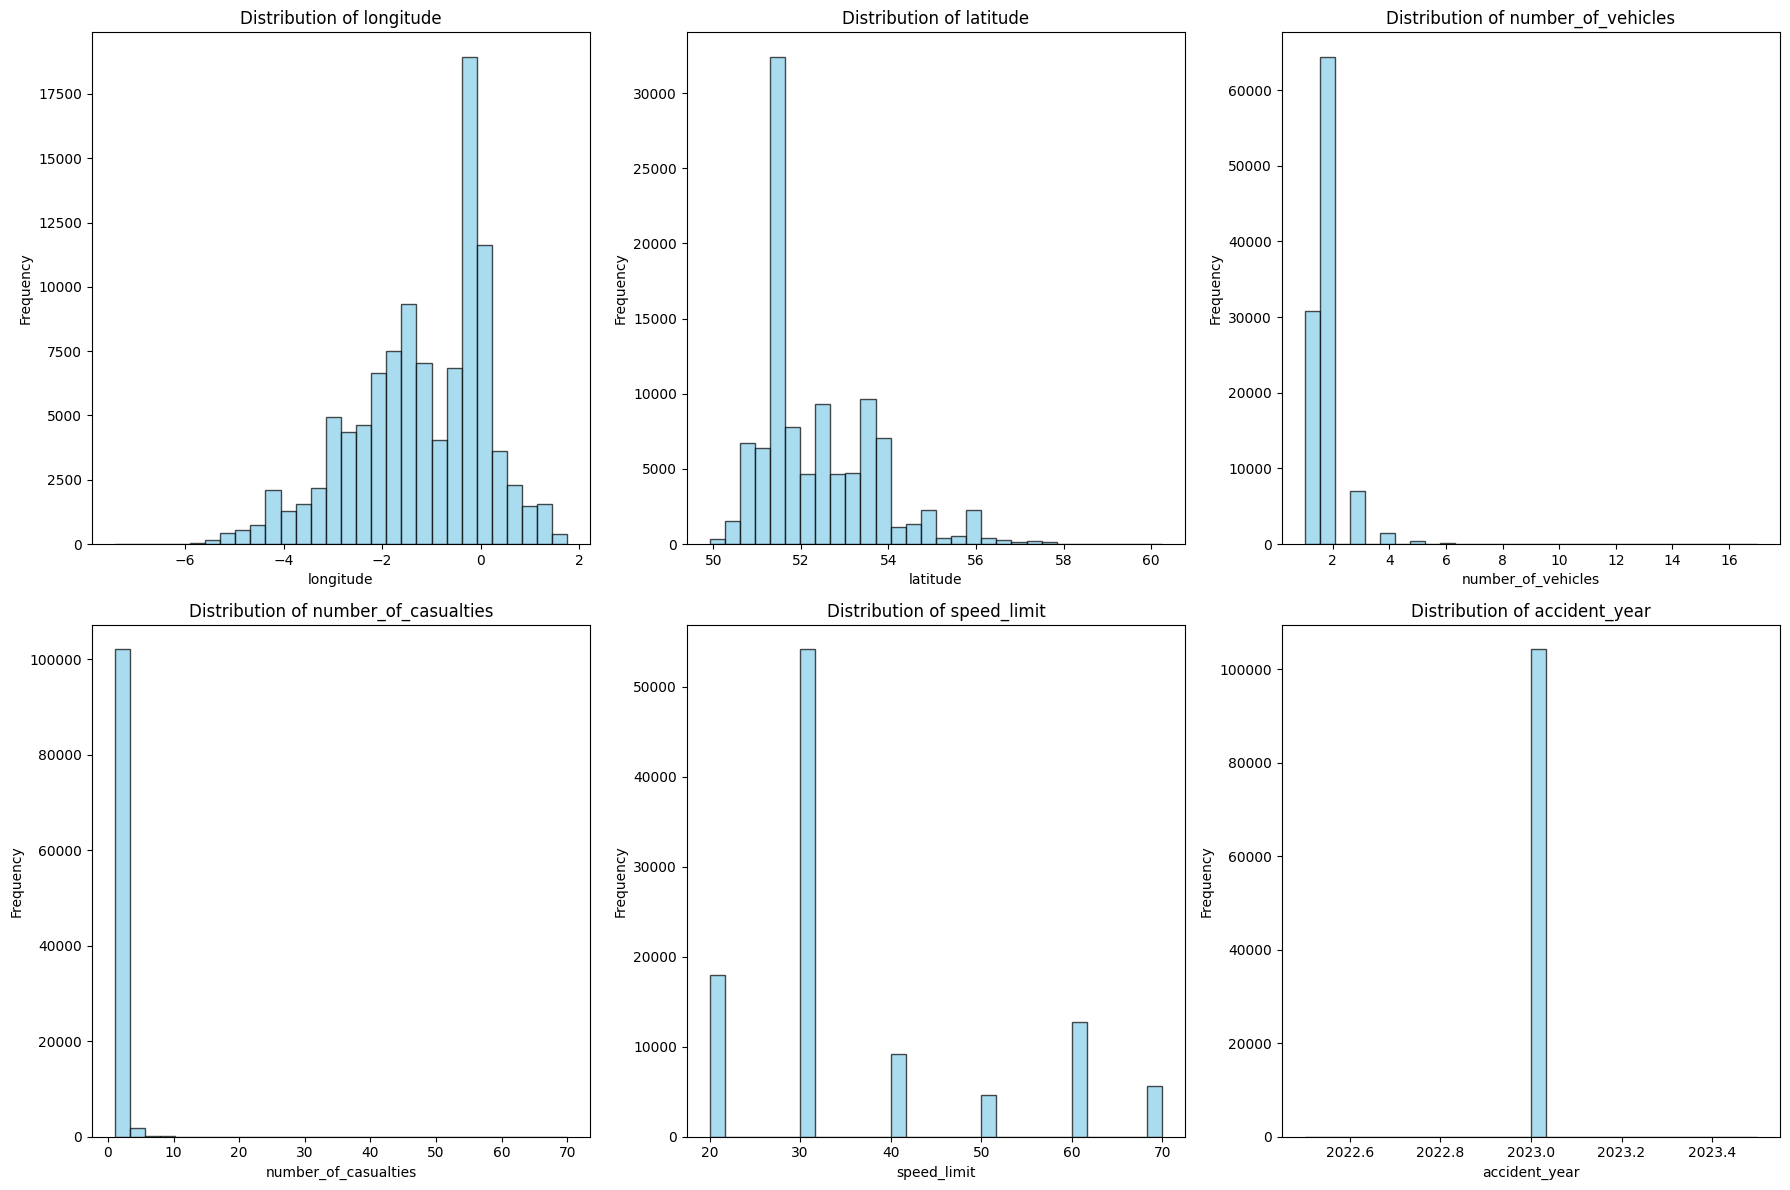

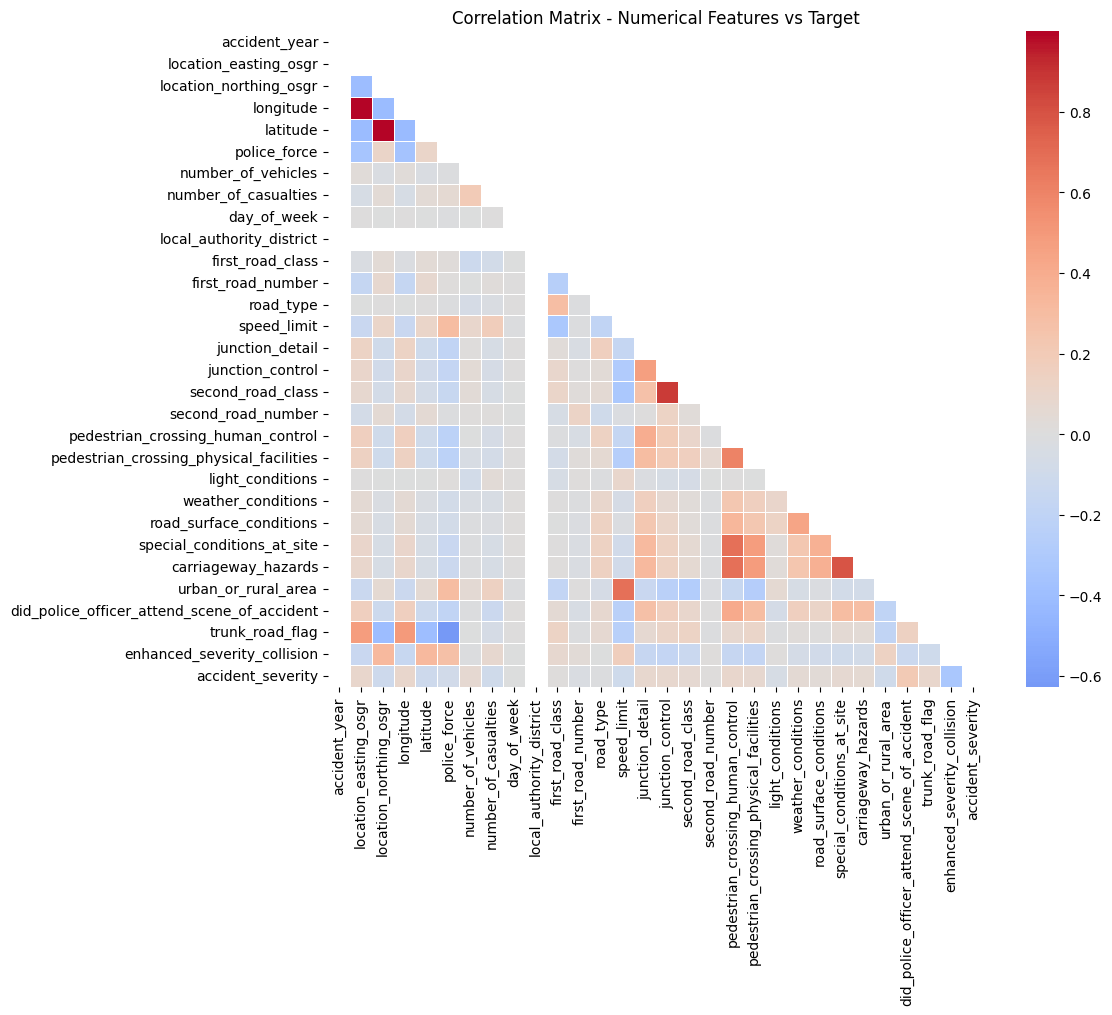


Correlation with Accident Severity:
accident_severity                              1.000000
did_police_officer_attend_scene_of_accident    0.207931
pedestrian_crossing_human_control              0.095617
trunk_road_flag                                0.089003
longitude                                      0.086324
location_easting_osgr                          0.084965
junction_control                               0.082452
junction_detail                                0.079475
pedestrian_crossing_physical_facilities        0.077083
special_conditions_at_site                     0.069975
second_road_class                              0.068245
number_of_vehicles                             0.067209
carriageway_hazards                            0.063568
weather_conditions                             0.047390
road_surface_conditions                        0.034216
second_road_number                             0.013285
first_road_class                               0.010583
day_of_week

In [9]:
# Identify numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
# Remove target from numerical analysis
if 'accident_severity' in numerical_cols:
    numerical_cols.remove('accident_severity')

print(f"Numerical columns: {numerical_cols}")
print(f"Number of numerical features: {len(numerical_cols)}")

# Descriptive statistics
print("\nDescriptive Statistics for Numerical Features:")
print(data[numerical_cols].describe())

# Distribution plots for key numerical variables
key_numerical = ['longitude', 'latitude', 'number_of_vehicles', 'number_of_casualties', 
                'speed_limit', 'accident_year']
key_numerical = [col for col in key_numerical if col in data.columns]

if key_numerical:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, col in enumerate(key_numerical[:6]):
        if i < len(axes):
            axes[i].hist(data[col].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = data[numerical_cols + ['accident_severity']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix - Numerical Features vs Target')
plt.tight_layout()
plt.show()

# Target correlation
target_corr = data[numerical_cols + ['accident_severity']].corr()['accident_severity'].sort_values(ascending=False)
print("\nCorrelation with Accident Severity:")
print(target_corr)

Categorical/Encoded columns: ['accident_index', 'accident_reference', 'date', 'time', 'local_authority_ons_district', 'local_authority_highway', 'lsoa_of_accident_location']
Number of categorical features: 7
Unique Values Count in Categorical Features:
accident_index: 104258 unique values
accident_reference: 104258 unique values
date: 365 unique values
time: 1440 unique values
local_authority_ons_district: 351 unique values
local_authority_highway: 208 unique values
lsoa_of_accident_location: 26838 unique values


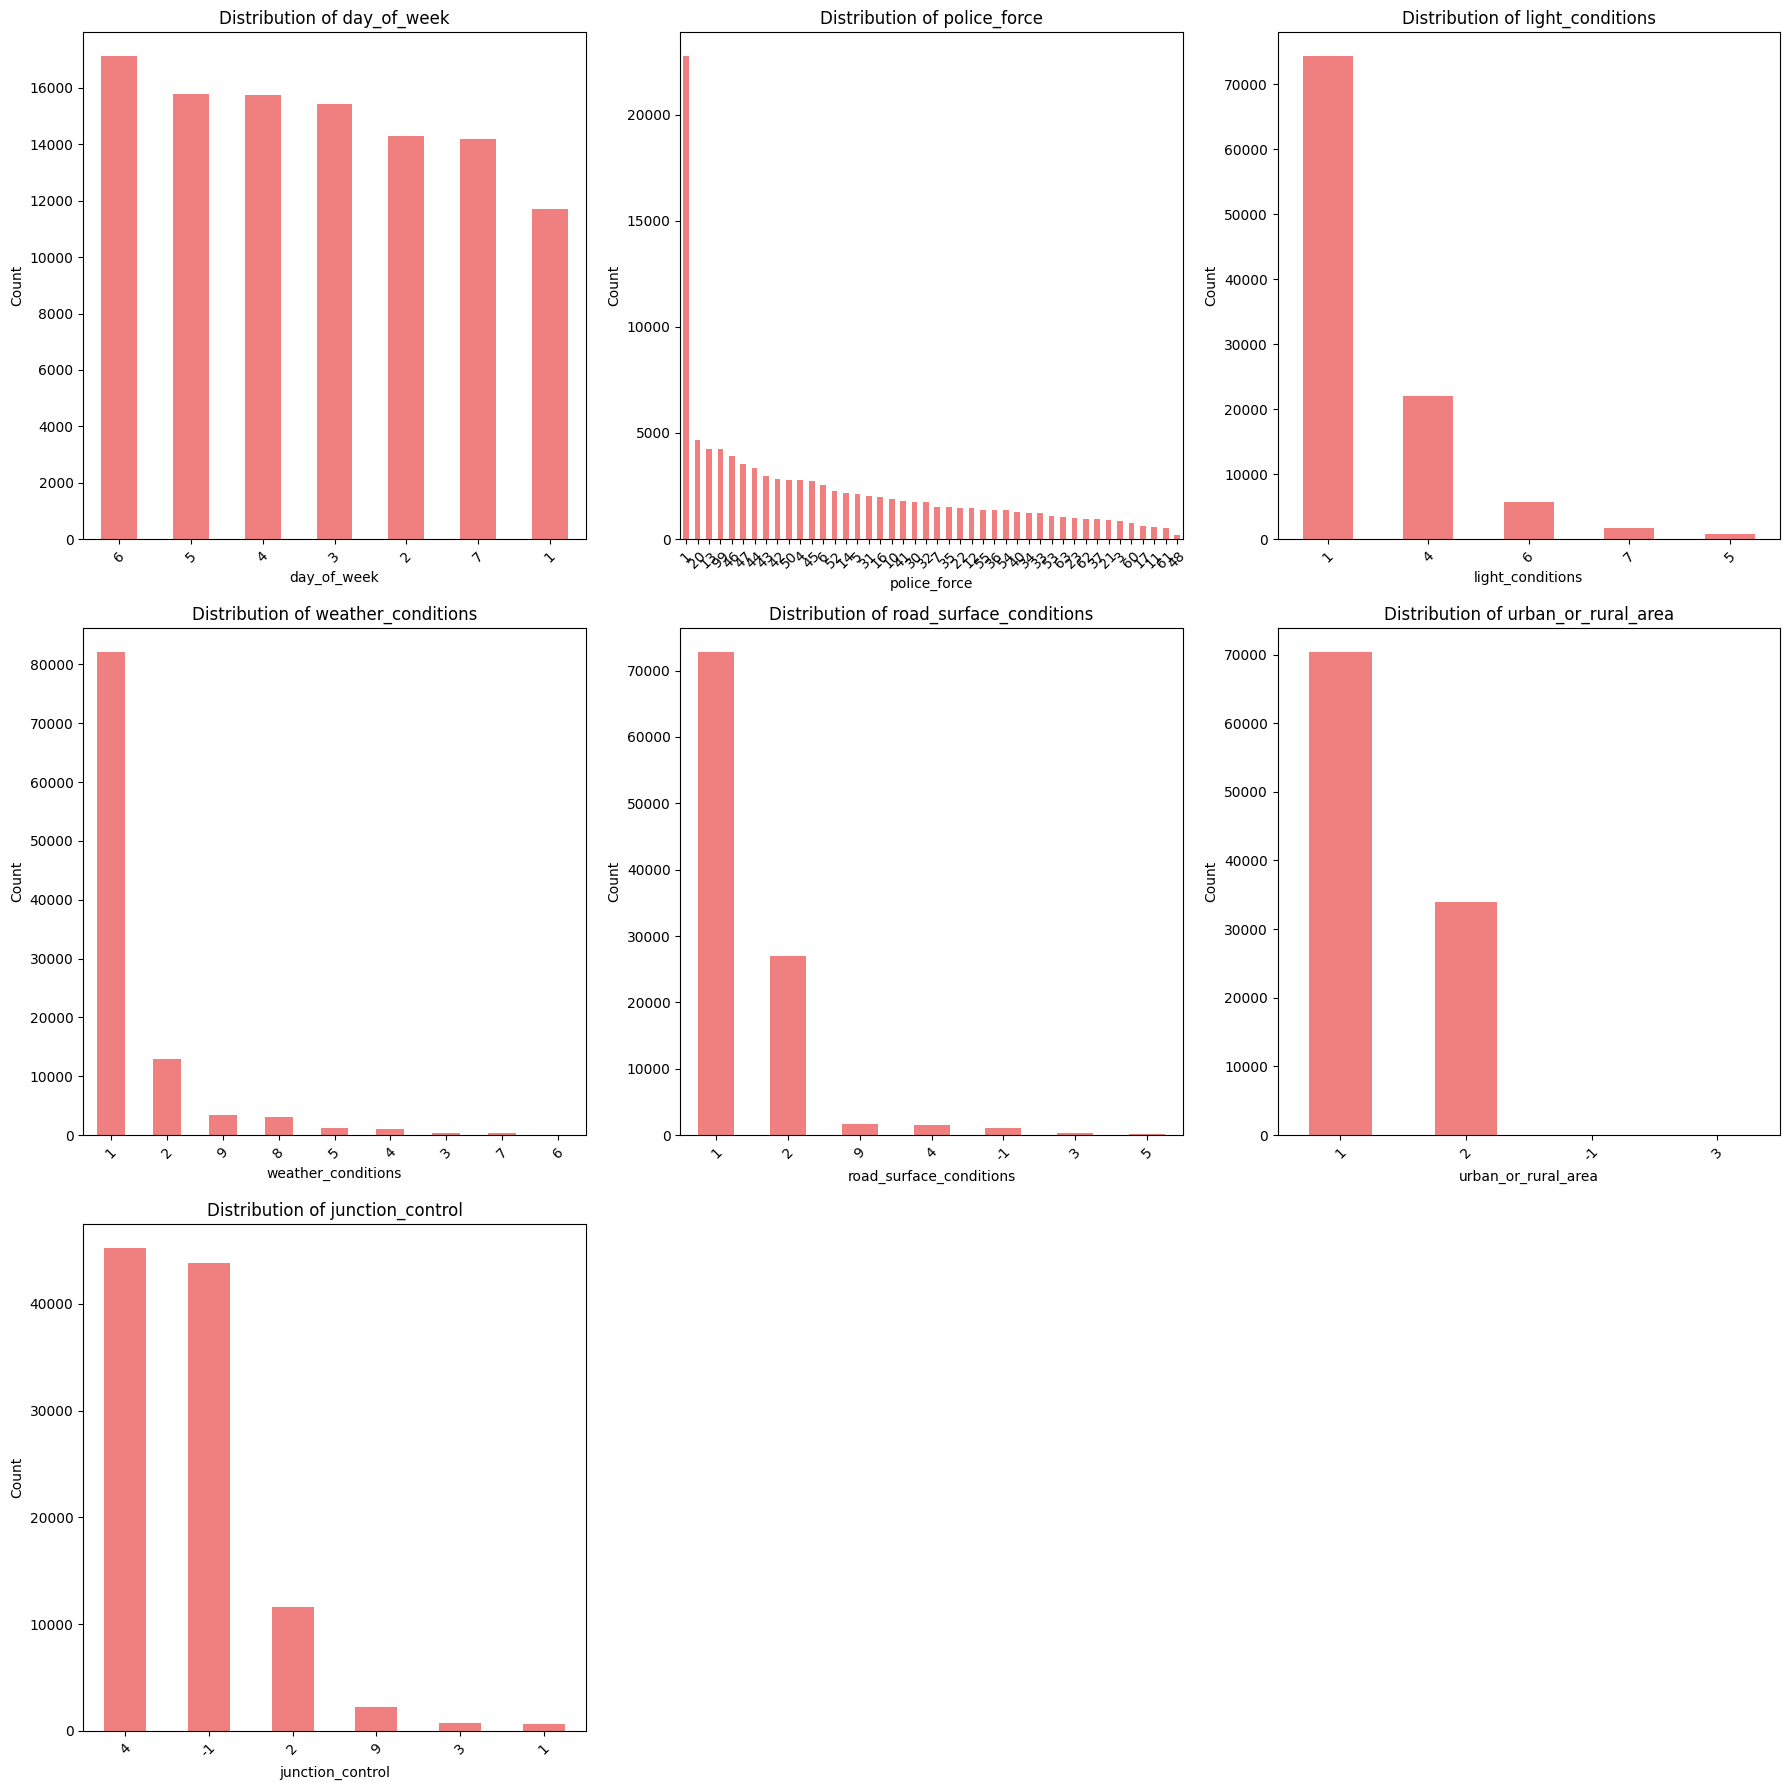

In [10]:
# Identify categorical columns (including encoded ones)
categorical_cols = []
for col in data.columns:
    if col not in numerical_cols and col != 'accident_severity':
        categorical_cols.append(col)

print(f"Categorical/Encoded columns: {categorical_cols}")
print(f"Number of categorical features: {len(categorical_cols)}")

# Unique values count for each categorical variable
print("Unique Values Count in Categorical Features:")
for col in categorical_cols:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")

# Analyze key categorical variables
key_categorical = ['day_of_week', 'police_force', 'light_conditions', 'weather_conditions', 
                  'road_surface_conditions', 'urban_or_rural_area', 'junction_control']
key_categorical = [col for col in key_categorical if col in data.columns]

# Distribution plots for key categorical variables
if key_categorical:
    n_cols = 3
    n_rows = (len(key_categorical) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(18, 6 * n_rows))
    
    for i, col in enumerate(key_categorical):
        plt.subplot(n_rows, n_cols, i + 1)
        data[col].value_counts().plot(kind='bar', color='lightcoral')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

Analyzing Numerical Features vs Accident Severity...


C:\Users\Yvonne\AppData\Local\Temp\ipykernel_13124\3332948206.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='accident_severity', y=col, palette='Set2')
C:\Users\Yvonne\AppData\Local\Temp\ipykernel_13124\3332948206.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='accident_severity', y=col, palette='Set2')
C:\Users\Yvonne\AppData\Local\Temp\ipykernel_13124\3332948206.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='accident_severity', y=col, palette='Set2')


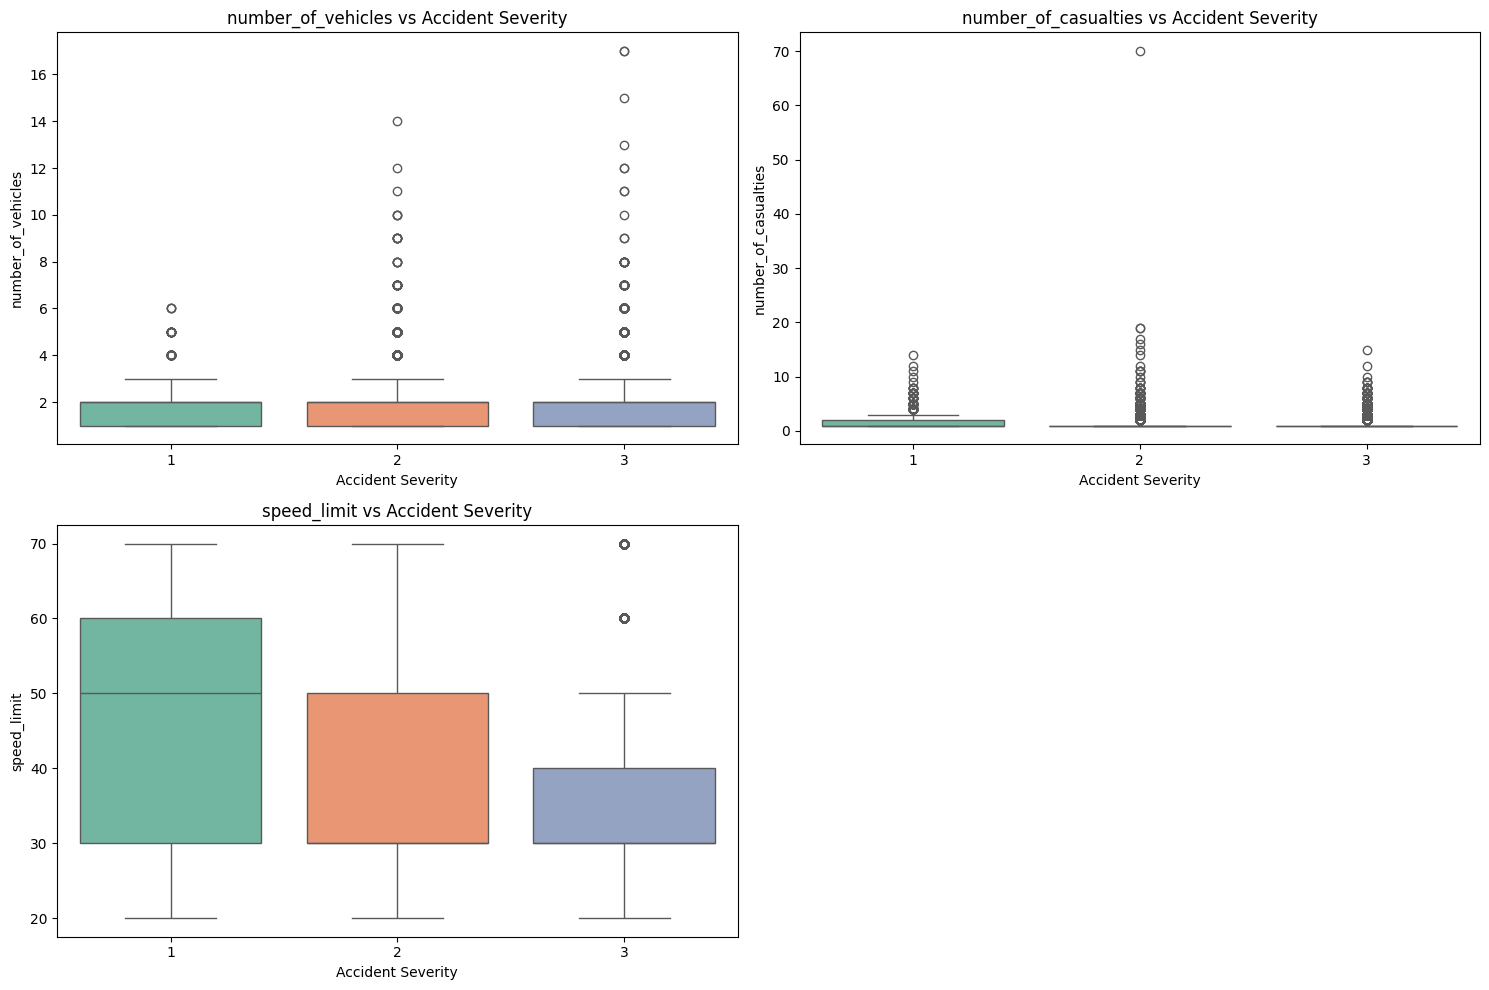

In [11]:
# Numerical features vs target
print("Analyzing Numerical Features vs Accident Severity...")

key_num_for_analysis = ['number_of_vehicles', 'number_of_casualties', 'speed_limit']
key_num_for_analysis = [col for col in key_num_for_analysis if col in data.columns]

if key_num_for_analysis:
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(key_num_for_analysis):
        plt.subplot(2, 2, i + 1)
        
        # Box plot
        sns.boxplot(data=data, x='accident_severity', y=col, palette='Set2')
        plt.title(f'{col} vs Accident Severity')
        plt.xlabel('Accident Severity')
        plt.ylabel(col)
    
    plt.tight_layout()
    plt.show()

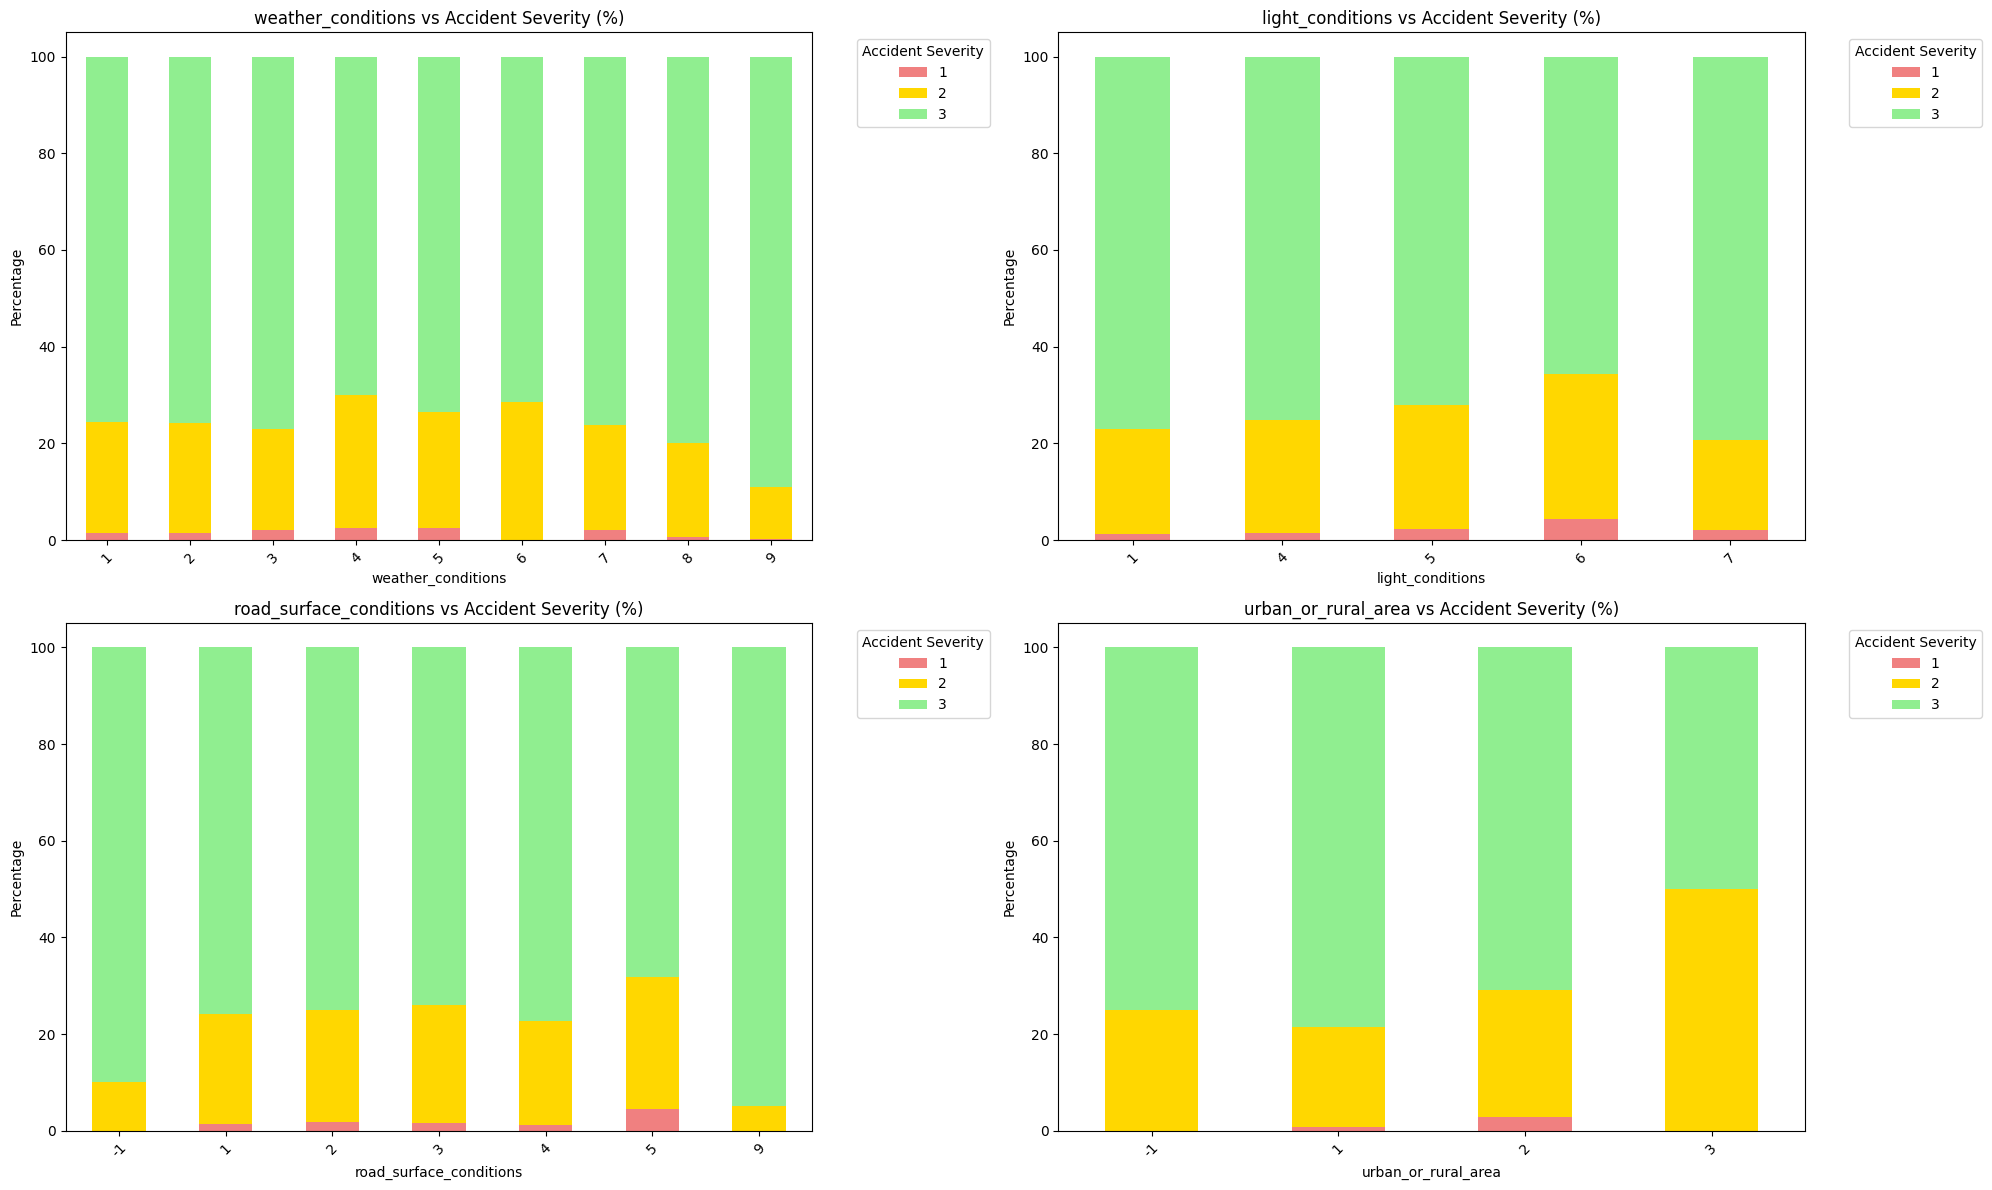

In [12]:
# Categorical features vs target

key_cat_for_analysis = ['weather_conditions', 'light_conditions', 'road_surface_conditions', 
                       'urban_or_rural_area']
key_cat_for_analysis = [col for col in key_cat_for_analysis if col in data.columns]

if key_cat_for_analysis:
    plt.figure(figsize=(20, 12))
    
    for i, col in enumerate(key_cat_for_analysis):
        plt.subplot(2, 2, i + 1)
        
        # Cross-tabulation
        ct = pd.crosstab(data[col], data['accident_severity'])
        ct_percent = pd.crosstab(data[col], data['accident_severity'], normalize='index') * 100
        
        ct_percent.plot(kind='bar', stacked=True, ax=plt.gca(), 
                       color=['lightcoral', 'gold', 'lightgreen'])
        plt.title(f'{col} vs Accident Severity (%)')
        plt.xlabel(col)
        plt.ylabel('Percentage')
        plt.legend(title='Accident Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

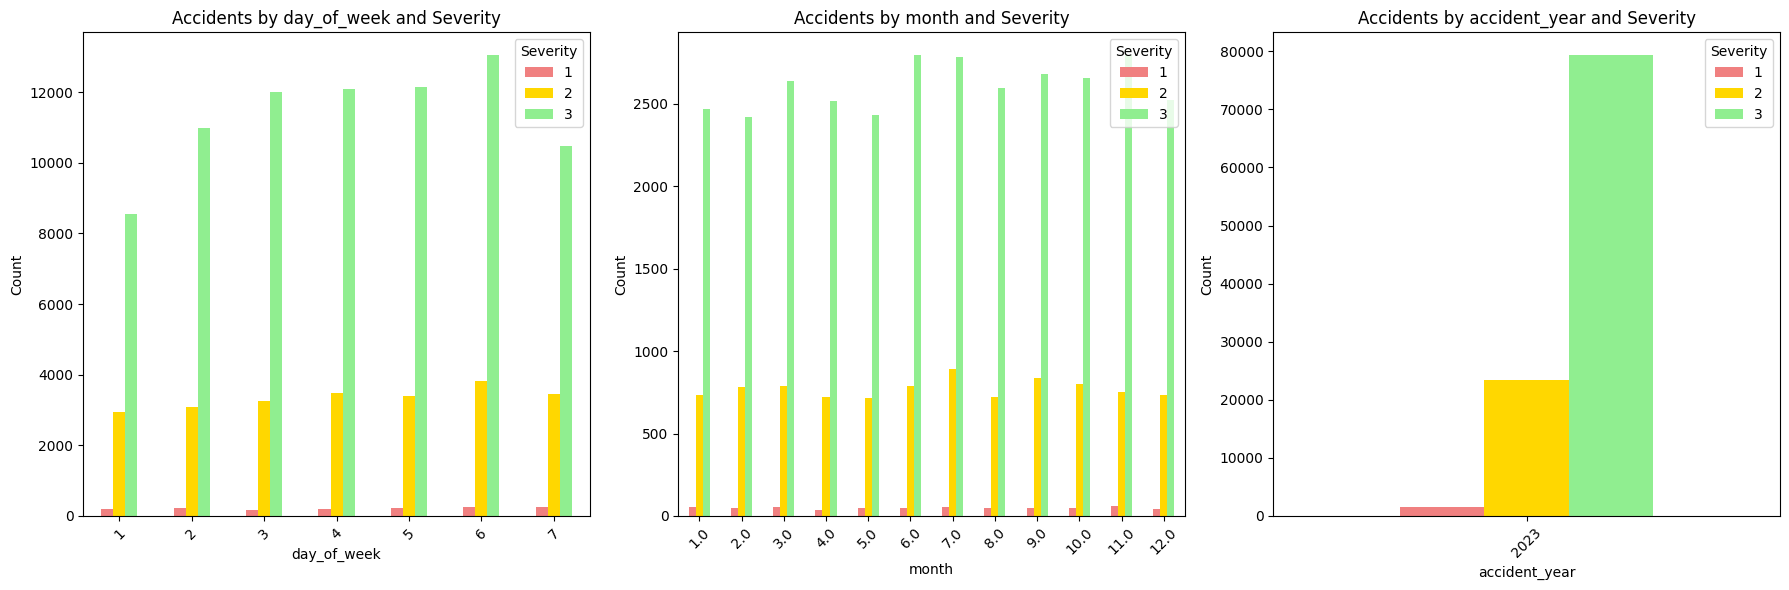

In [13]:
# Convert date and time if they exist
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day

# Time-based patterns
time_features = ['day_of_week', 'month', 'accident_year']
time_features = [col for col in time_features if col in data.columns]

if time_features:
    plt.figure(figsize=(18, 6))
    
    for i, col in enumerate(time_features):
        if col in data.columns:
            plt.subplot(1, len(time_features), i + 1)
            
            # Accidents by time feature and severity
            ct = pd.crosstab(data[col], data['accident_severity'])
            ct.plot(kind='bar', ax=plt.gca(), color=['lightcoral', 'gold', 'lightgreen'])
            plt.title(f'Accidents by {col} and Severity')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.legend(title='Severity')
            plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

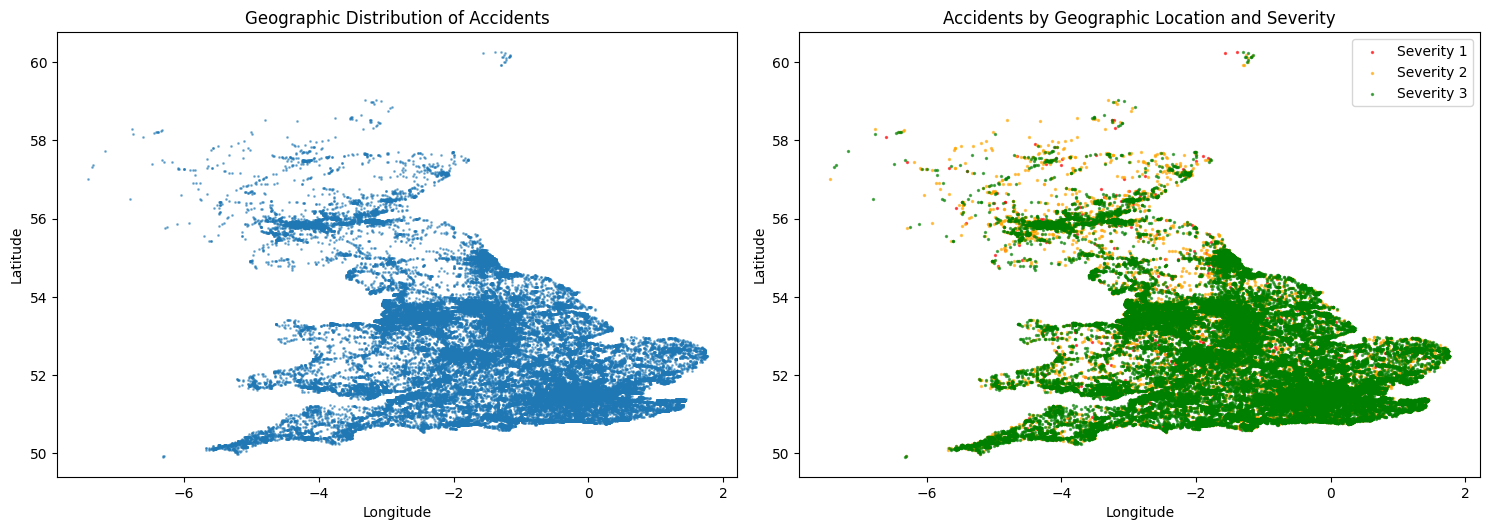

In [14]:
#GEOSPATIAL ANALYSIS

if 'longitude' in data.columns and 'latitude' in data.columns:
    plt.figure(figsize=(15, 10))
    
    # Geographic distribution
    plt.subplot(2, 2, 1)
    plt.scatter(data['longitude'], data['latitude'], alpha=0.5, s=1)
    plt.title('Geographic Distribution of Accidents')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Geographic distribution by severity
    plt.subplot(2, 2, 2)
    colors = ['red', 'orange', 'green']
    for severity in sorted(data['accident_severity'].unique()):
        mask = data['accident_severity'] == severity
        plt.scatter(data.loc[mask, 'longitude'], data.loc[mask, 'latitude'], 
                   alpha=0.6, s=2, label=f'Severity {severity}', c=colors[int(severity)-1])
    plt.title('Accidents by Geographic Location and Severity')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

number_of_vehicles outliers: 2012 (1.93%)
number_of_casualties outliers: 19306 (18.52%)
speed_limit outliers: 18392 (17.64%)


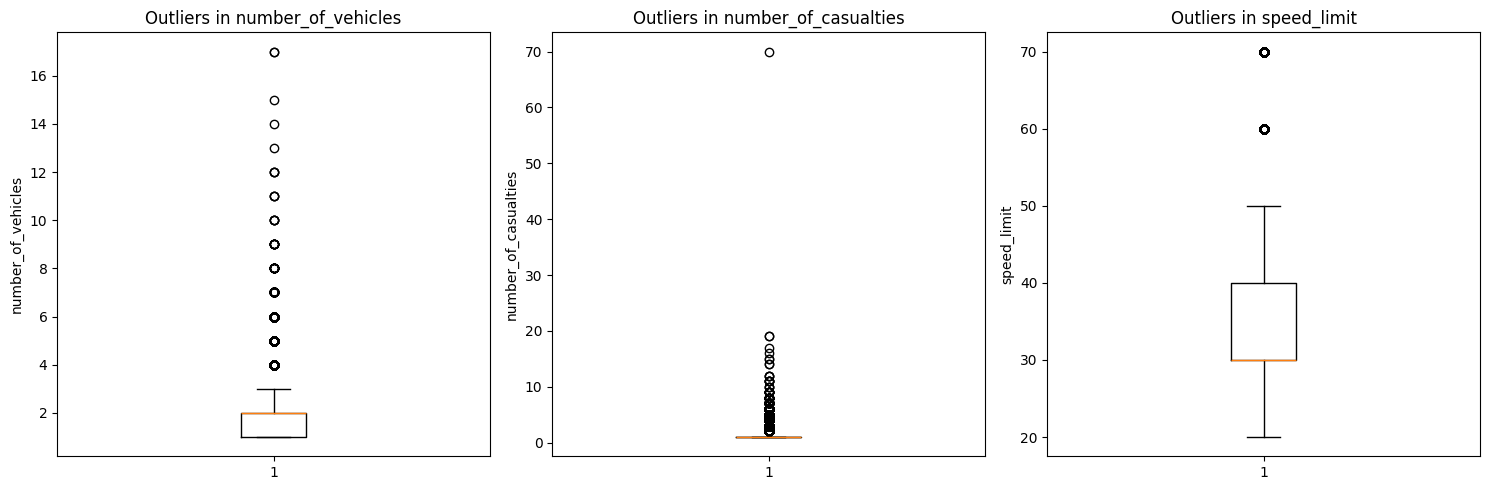

In [15]:
# Outlier detection for key numerical variables
outlier_cols = ['number_of_vehicles', 'number_of_casualties', 'speed_limit']
outlier_cols = [col for col in outlier_cols if col in data.columns]

if outlier_cols:
    plt.figure(figsize=(15, 5))
    
    for i, col in enumerate(outlier_cols):
        plt.subplot(1, len(outlier_cols), i + 1)
        
        # Box plot for outliers
        plt.boxplot(data[col].dropna())
        plt.title(f'Outliers in {col}')
        plt.ylabel(col)
        
        # Calculate and print outlier statistics
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        print(f"{col} outliers: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")
    
    plt.tight_layout()
    plt.show()


In [16]:
data.shape

(104258, 39)

In [17]:
data.columns.tolist()

['accident_index',
 'accident_year',
 'accident_reference',
 'location_easting_osgr',
 'location_northing_osgr',
 'longitude',
 'latitude',
 'police_force',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'date',
 'day_of_week',
 'time',
 'local_authority_district',
 'local_authority_ons_district',
 'local_authority_highway',
 'first_road_class',
 'first_road_number',
 'road_type',
 'speed_limit',
 'junction_detail',
 'junction_control',
 'second_road_class',
 'second_road_number',
 'pedestrian_crossing_human_control',
 'pedestrian_crossing_physical_facilities',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'special_conditions_at_site',
 'carriageway_hazards',
 'urban_or_rural_area',
 'did_police_officer_attend_scene_of_accident',
 'trunk_road_flag',
 'lsoa_of_accident_location',
 'enhanced_severity_collision',
 'month',
 'day']

### **Exploratory Data Analysis (EDA)**

In [18]:
import pandas as pd
import numpy as np

def decode_stats19_features(data):
    """
    Decodes all STATS19 coded features into human-readable labels.
    Returns a new DataFrame with decoded columns added.
    """
    
    df_decoded = data.copy()
    
    # 1. Decode first_road_class
    road_class_map = {
        1: 'Motorway',
        2: 'A(M) Motorway',
        3: 'A road',
        4: 'B road',
        5: 'C road',
        6: 'Unclassified'
    }
    df_decoded['first_road_class_decoded'] = df_decoded['first_road_class'].map(road_class_map).fillna('Unknown')
    
    # 2. Decode second_road_class (also used to create is_junction later)
    df_decoded['second_road_class_decoded'] = df_decoded['second_road_class'].map(road_class_map).fillna('No second road')
    # For second_road_number, we'll just note if it exists
    df_decoded['has_second_road'] = (df_decoded['second_road_class'] != -1).astype(int)
    
    # 3. Decode junction_detail
    junction_detail_map = {
        0: 'Not at junction',
        1: 'Roundabout',
        2: 'Mini-roundabout',
        3: 'T or staggered junction',
        4: 'T or staggered junction',  # Sometimes 3 and 4 are both T-junction types
        5: 'Slip road',
        6: 'Crossroads',
        7: 'More than 4 arms',
        8: 'Private drive',
        9: 'Other junction'
    }
    df_decoded['junction_detail_decoded'] = df_decoded['junction_detail'].map(junction_detail_map).fillna('Unknown')
    
    # 4. Decode junction_control
    junction_control_map = {
        0: 'Not at junction',
        1: 'Authorised person',
        2: 'Auto traffic signal',
        3: 'Stop sign',
        4: 'Give way',
        5: 'Police officer',
        6: 'Traffic warden'
    }
    df_decoded['junction_control_decoded'] = df_decoded['junction_control'].map(junction_control_map).fillna('Unknown')
    
    # 5. Decode road_type
    road_type_map = {
        1: 'Roundabout',
        2: 'One way street',
        3: 'Dual carriageway',
        6: 'Single carriageway',
        7: 'Slip road',
        9: 'Unknown'
    }
    df_decoded['road_type_decoded'] = df_decoded['road_type'].map(road_type_map).fillna('Unknown')
    
    # 6. Decode pedestrian_crossing_human_control
    pedestrian_human_map = {
        0: 'None within 50 metres',
        1: 'Control by school crossing patrol',
        2: 'Control by other authorised person'
    }
    df_decoded['pedestrian_crossing_human_decoded'] = df_decoded['pedestrian_crossing_human_control'].map(pedestrian_human_map).fillna('Unknown')
    
    # 7. Decode pedestrian_crossing_physical_facilities
    pedestrian_physical_map = {
        0: 'No physical crossing within 50 metres',
        1: 'Zebra crossing',
        4: 'Pelican, puffin, toucan or similar non-junction pedestrian light crossing',
        5: 'Pedestrian phase at traffic signal junction',
        7: 'Footbridge or subway',
        8: 'Central refuge'
    }
    df_decoded['pedestrian_crossing_physical_decoded'] = df_decoded['pedestrian_crossing_physical_facilities'].map(pedestrian_physical_map).fillna('Unknown')
    
    # 8. Decode light_conditions
    light_conditions_map = {
        1: 'Daylight',
        4: 'Darkness - lights lit',
        5: 'Darkness - lights unlit',
        6: 'Darkness - no lighting',
        7: 'Darkness - lighting unknown'
    }
    df_decoded['light_conditions_decoded'] = df_decoded['light_conditions'].map(light_conditions_map).fillna('Unknown')
    
    # 9. Decode weather_conditions
    weather_conditions_map = {
        1: 'Fine no high winds',
        2: 'Raining no high winds',
        3: 'Snowing no high winds',
        4: 'Fine + high winds',
        5: 'Raining + high winds',
        6: 'Snowing + high winds',
        7: 'Fog or mist',
        8: 'Other',
        9: 'Unknown'
    }
    df_decoded['weather_conditions_decoded'] = df_decoded['weather_conditions'].map(weather_conditions_map).fillna('Unknown')
    
    # 10. Decode road_surface_conditions
    road_surface_map = {
        1: 'Dry',
        2: 'Wet or damp',
        3: 'Snow',
        4: 'Frost or ice',
        5: 'Flood over 3cm deep',
        6: 'Oil or diesel',
        7: 'Mud'
    }
    df_decoded['road_surface_conditions_decoded'] = df_decoded['road_surface_conditions'].map(road_surface_map).fillna('Unknown')
    
    # 11. Decode special_conditions_at_site
    special_conditions_map = {
        0: 'None',
        1: 'Auto traffic signal out',
        2: 'Auto traffic signal defective',
        3: 'Road sign or marking defective or obscured',
        4: 'Roadworks',
        5: 'Road surface defective',
        6: 'Oil or diesel',
        7: 'Mud'
    }
    df_decoded['special_conditions_decoded'] = df_decoded['special_conditions_at_site'].map(special_conditions_map).fillna('Unknown')
    
    # 12. Decode carriageway_hazards
    carriageway_hazards_map = {
        0: 'None',
        1: 'Vehicle load on road',
        2: 'Other object on road',
        3: 'Involvement with previous accident',
        4: 'Dog on road',
        5: 'Other animal on road',
        6: 'Pedestrian in carriageway - not injured',
        7: 'Any animal in carriageway (except ridden horse)'
    }
    df_decoded['carriageway_hazards_decoded'] = df_decoded['carriageway_hazards'].map(carriageway_hazards_map).fillna('Unknown')
    
    # 13. Decode urban_or_rural_area
    urban_rural_map = {
        1: 'Urban',
        2: 'Rural',
        3: 'Unallocated'
    }
    df_decoded['urban_rural_decoded'] = df_decoded['urban_or_rural_area'].map(urban_rural_map).fillna('Unknown')
    
    # 14. Handle date and time
    # df_decoded['date'] = pd.to_datetime(df_decoded['date'], dayfirst=True, errors='coerce')
    # df_decoded['time'] = pd.to_datetime(df_decoded['time'], format='%H:%M', errors='coerce').dt.time
    
    # Extract day of week name
    day_of_week_map = {
        1: 'Sunday',
        2: 'Monday',
        3: 'Tuesday',
        4: 'Wednesday',
        5: 'Thursday',
        6: 'Friday',
        7: 'Saturday'
    }
    df_decoded['day_of_week_name'] = df_decoded['day_of_week'].map(day_of_week_map).fillna('Unknown')
    
    return df_decoded

# Usage:
# df = pd.read_csv('road-casualty-statistics-collision.csv')
df_decoded = decode_stats19_features(data)

# # Now you can see your decoded data
# print(df_decoded[['first_road_class', 'first_road_class_decoded', 
#                  'light_conditions', 'light_conditions_decoded',
#                  'weather_conditions', 'weather_conditions_decoded']].head(10))

In [19]:
print(df_decoded[['first_road_class', 'first_road_class_decoded', 
                 'light_conditions', 'light_conditions_decoded',
                 'weather_conditions', 'weather_conditions_decoded']].head(5))

   first_road_class first_road_class_decoded  light_conditions  \
0                 5                   C road                 4   
1                 6             Unclassified                 4   
2                 3                   A road                 4   
3                 3                   A road                 4   
4                 3                   A road                 4   

  light_conditions_decoded  weather_conditions weather_conditions_decoded  
0    Darkness - lights lit                   8                      Other  
1    Darkness - lights lit                   1         Fine no high winds  
2    Darkness - lights lit                   1         Fine no high winds  
3    Darkness - lights lit                   9                    Unknown  
4    Darkness - lights lit                   1         Fine no high winds  


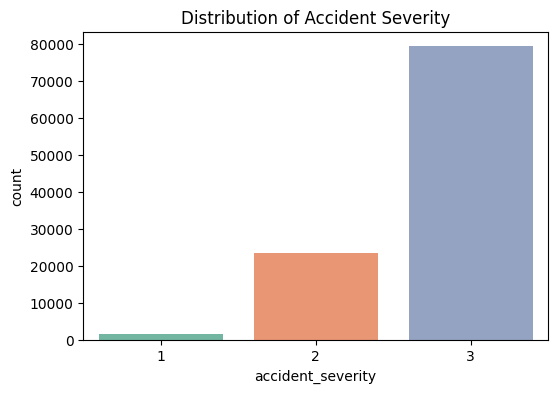

Target class distribution:   accident_severity
3    79298
2    23438
1     1522
Name: count, dtype: int64


In [20]:
#Target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(
    x="accident_severity",
    hue="accident_severity",
    data=data,
    palette="Set2",
    legend=False)
plt.title("Distribution of Accident Severity")
plt.show()

print("Target class distribution:  ", (data["accident_severity"]).value_counts())

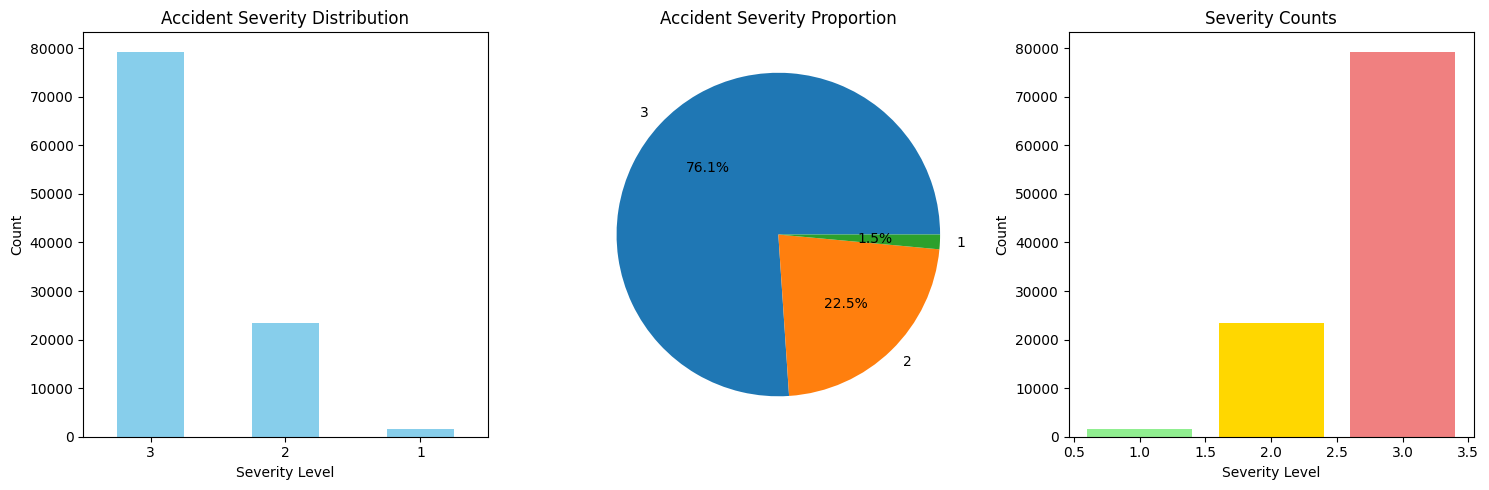

In [21]:
# Target distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
data['accident_severity'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Accident Severity Distribution')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 3, 2)
data['accident_severity'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Accident Severity Proportion')
plt.ylabel('')

plt.subplot(1, 3, 3)
severity_counts = data['accident_severity'].value_counts()
plt.bar(severity_counts.index, severity_counts.values, color=['lightcoral', 'gold', 'lightgreen'])
plt.title('Severity Counts')
plt.xlabel('Severity Level')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**As seen, there is an imbalance in the dataset's representation of the target variable.**

In [22]:
# Check for class imbalance
imbalance_ratio = data['accident_severity'].value_counts().max() / data['accident_severity'].value_counts().min()
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")

Class Imbalance Ratio: 52.10


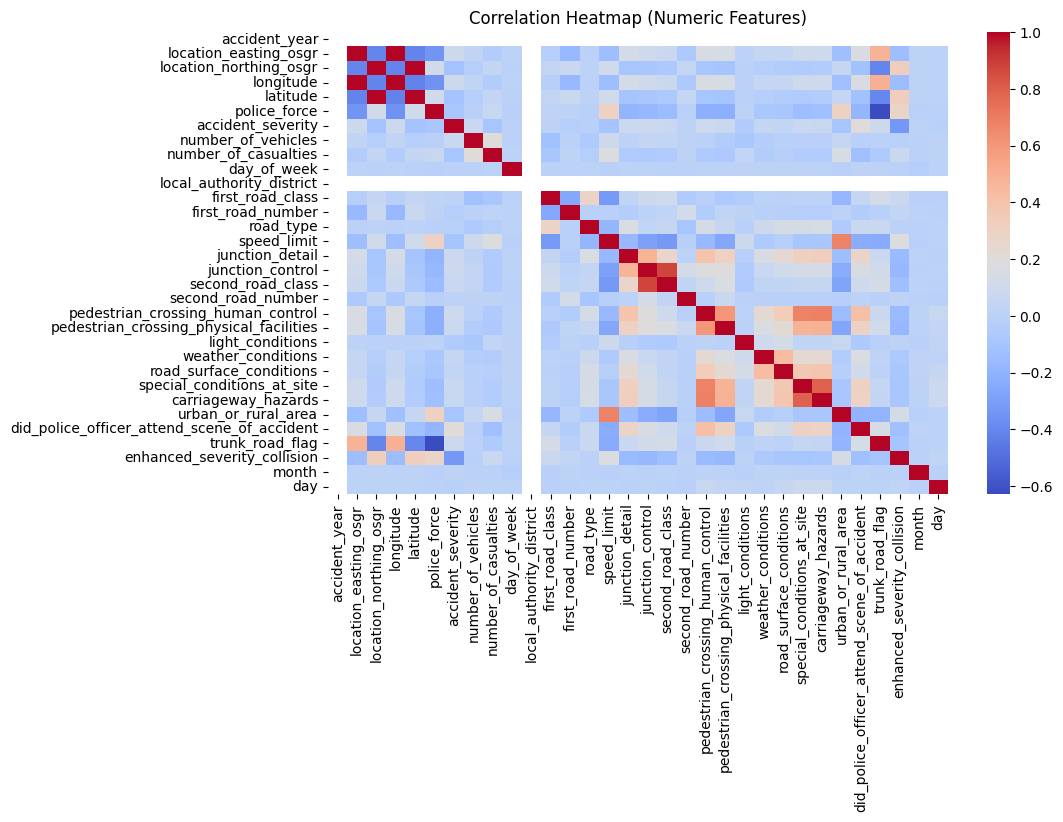

In [23]:
# Correlation matrix (numeric only)
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [24]:
from scipy.stats import chi2_contingency
for col in cat_var.columns:
    table = pd.crosstab(data[col], data['accident_severity'])
    chi2, p, dof, ex = chi2_contingency(table)
    print(f"{col}: p={p}")

accident_index: p=0.4983526197573337
accident_reference: p=0.4983526197573337
date: p=3.1673795036011637e-06
time: p=4.470185787298401e-82
local_authority_ons_district: p=0.0
local_authority_highway: p=0.0
lsoa_of_accident_location: p=4.022252836021567e-40


**The results show that the time and location (both the specific area and the governing authority) of an accident are highly significant and not independent of the accident outcome, while the unique ID numbers, as expected, are irrelevant.**

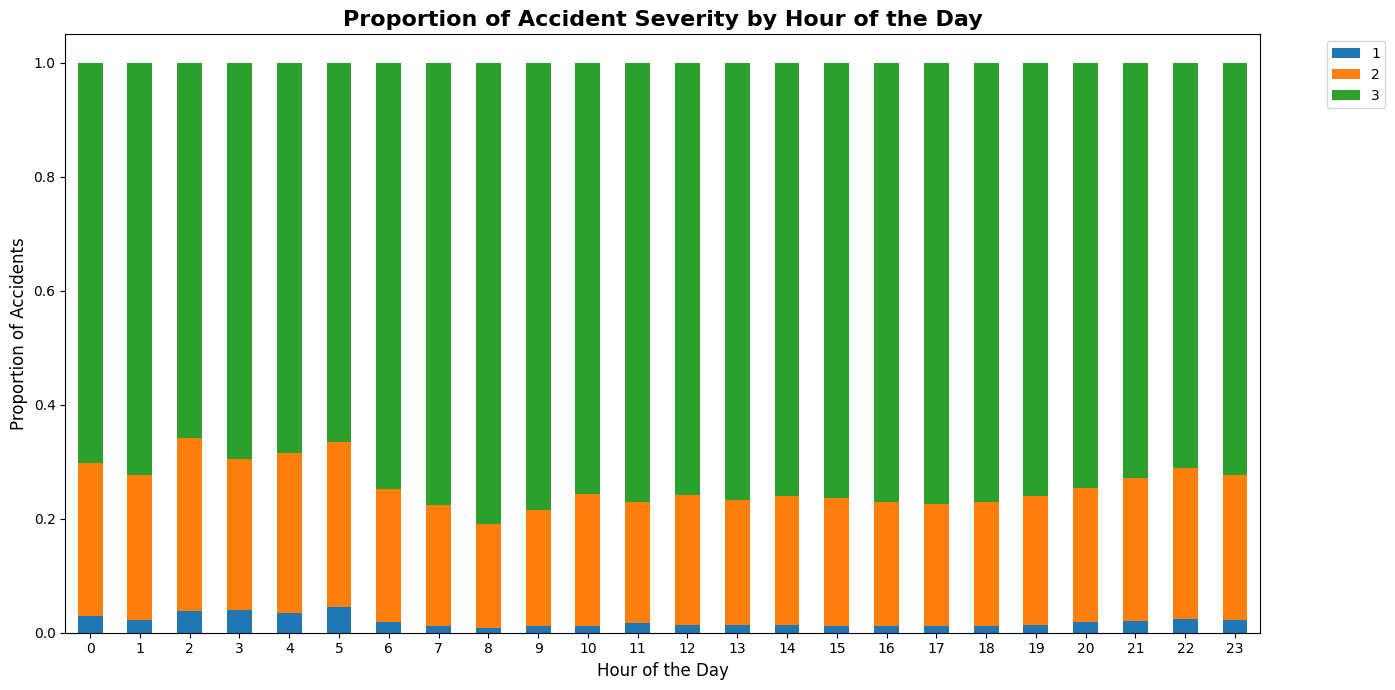

In [25]:
# 1. Extract the hour from the 'time' column
# Assuming 'time' is in a format like "17:30"
data['hour'] = pd.to_datetime(data['time'], format='%H:%M').dt.hour

# 2. Create a cross-tabulation of hour vs. severity, normalized by hour to show proportions.
time_severity_ct = pd.crosstab(data['hour'], data['accident_severity'], normalize='index')

# 3. Plot the data
ax = time_severity_ct.plot(kind='bar', stacked=True, figsize=(14, 7))

# 4. Customize the plot
plt.title('Proportion of Accident Severity by Hour of the Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Proportion of Accidents', fontsize=12)
plt.legend(title='Severity', labels=['Fatal', 'Serious', 'Slight']) 
plt.xticks(rotation=0)

# This moves the legend outside the plot so it's not blocking bars
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

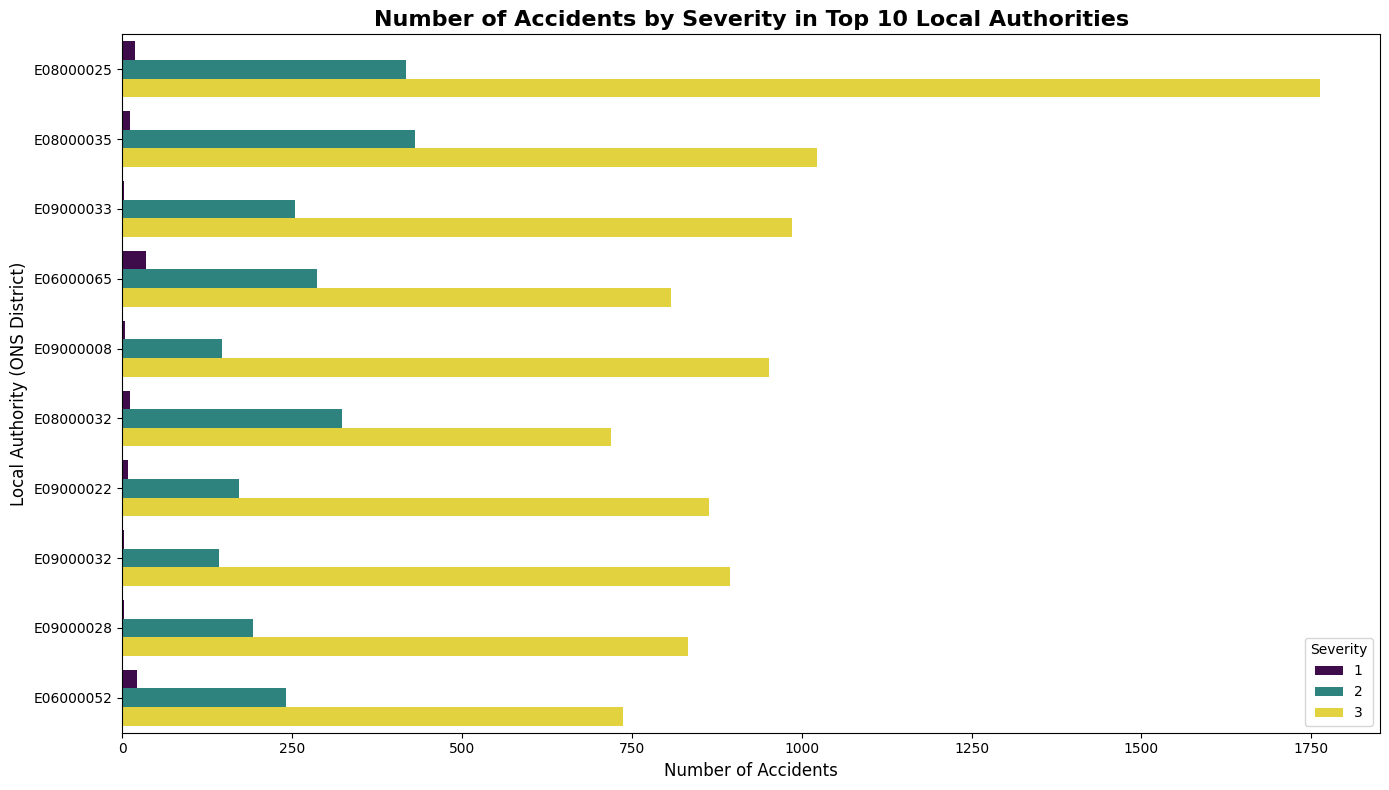

In [26]:
# 1. Get the top 10 most frequent authorities
top_10_authorities = data['local_authority_ons_district'].value_counts().head(10).index

# 2. Filter the dataframe to only include these top 10
df_top_authorities = data[data['local_authority_ons_district'].isin(top_10_authorities)]

# 3. Create a countplot
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=df_top_authorities, 
                   y='local_authority_ons_district', 
                   hue='accident_severity', 
                   order=top_10_authorities, 
                   palette='viridis') # You can change the palette

# 4. Customize the plot
plt.title('Number of Accidents by Severity in Top 10 Local Authorities', fontsize=16, fontweight='bold')
plt.xlabel('Number of Accidents', fontsize=12)
plt.ylabel('Local Authority (ONS District)', fontsize=12)
plt.legend(title='Severity')
# Adding data labels on the bars can be messy for a countplot, so it's often skipped.
plt.tight_layout()
plt.show()

In [27]:
data.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2023010419171           2023          010419171               525060.0   
1  2023010419183           2023          010419183               535463.0   
2  2023010419189           2023          010419189               508702.0   
3  2023010419191           2023          010419191               520341.0   
4  2023010419192           2023          010419192               527255.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                170416.0  -0.202878  51.418974             1   
1                198745.0  -0.042464  51.671155             1   
2                177696.0  -0.435789  51.487777             1   
3                190175.0  -0.263972  51.597575             1   
4                176963.0  -0.168976  51.477324             1   

   accident_severity  number_of_vehicles  ...  special_conditions_at_site  \
0                  3                   1  ...                           0   
1                  3                   3  ...                           0   
2                  3                   2  ...                           0   
3                  3                   2  ...                           0   
4                  3                   2  ...                           0   

  carriageway_hazards  urban_or_rural_area  \
0                   0                    1   
1                   0                    1   
2                   0                    1   
3                   0                    1   
4                   0                    1   

  did_police_officer_attend_scene_of_accident  trunk_road_flag  \
0                                           1                2   
1                                           1                2   
2                                           1                2   
3                                           1                2   
4                                           1                2   

  lsoa_of_accident_location enhanced_severity_collision  month  day  hour  
0                 E01003383                          -1    1.0  1.0     1  
1                 E01001547                          -1    1.0  1.0     2  
2                 E01002448                          -1    1.0  1.0     3  
3                 E01000129                          -1    1.0  1.0     2  
4                 E01004583                          -1    1.0  1.0     1  

[5 rows x 40 columns]

In [28]:
# # 1. Ensure 'date' is a datetime object
# data['date_dt'] = pd.to_datetime(data['date'])

# # 2. Set the date as the index and sort it
# data_time_series = data.set_index('date_dt').sort_index()

# # 3. Resample by week ('W') or month ('M') to get a smoother trend
# # Here we use weekly frequency and count the number of accidents per week
# weekly_accidents = data_time_series.resample('W').size()

# # 4. Plot the time series
# plt.figure(figsize=(16, 6))
# weekly_accidents.plot()
# plt.title('Trend of Accidents Over Time (Weekly Aggregation)', fontsize=16, fontweight='bold')
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Number of Accidents per Week', fontsize=12)
# plt.grid(True, which='both')
# plt.tight_layout()
# plt.show()

### **Data Preprocessing**

In [29]:
data.isnull().sum()

accident_index                                     0
accident_year                                      0
accident_reference                                 0
location_easting_osgr                             12
location_northing_osgr                            12
longitude                                         12
latitude                                          12
police_force                                       0
accident_severity                                  0
number_of_vehicles                                 0
number_of_casualties                               0
date                                           63092
day_of_week                                        0
time                                               0
local_authority_district                           0
local_authority_ons_district                       0
local_authority_highway                            0
first_road_class                                   0
first_road_number                             

In [30]:
data.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2023010419171           2023          010419171               525060.0   
1  2023010419183           2023          010419183               535463.0   
2  2023010419189           2023          010419189               508702.0   
3  2023010419191           2023          010419191               520341.0   
4  2023010419192           2023          010419192               527255.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                170416.0  -0.202878  51.418974             1   
1                198745.0  -0.042464  51.671155             1   
2                177696.0  -0.435789  51.487777             1   
3                190175.0  -0.263972  51.597575             1   
4                176963.0  -0.168976  51.477324             1   

   accident_severity  number_of_vehicles  ...  special_conditions_at_site  \
0                  3                   1  ...                           0   
1                  3                   3  ...                           0   
2                  3                   2  ...                           0   
3                  3                   2  ...                           0   
4                  3                   2  ...                           0   

  carriageway_hazards  urban_or_rural_area  \
0                   0                    1   
1                   0                    1   
2                   0                    1   
3                   0                    1   
4                   0                    1   

  did_police_officer_attend_scene_of_accident  trunk_road_flag  \
0                                           1                2   
1                                           1                2   
2                                           1                2   
3                                           1                2   
4                                           1                2   

  lsoa_of_accident_location enhanced_severity_collision  month  day  hour  
0                 E01003383                          -1    1.0  1.0     1  
1                 E01001547                          -1    1.0  1.0     2  
2                 E01002448                          -1    1.0  1.0     3  
3                 E01000129                          -1    1.0  1.0     2  
4                 E01004583                          -1    1.0  1.0     1  

[5 rows x 40 columns]

In [31]:
# Drop irrelevant columns 
drop_cols = [
    "accident_index", "accident_reference", 
    "accident_year", "enhanced_severity_collision",
    "local_authority_district"
    #"lsoa_of_accident_location",
    #, "local_authority_highway"
    #"local_authority_ons_district", 
    #"location_easting_osgr", "longitude"
    #"location_northing_osgr", "latitude"
]

df = data.drop(columns=drop_cols, errors="ignore")


In [32]:
from sklearn.cluster import KMeans

#Handle date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month"] = df["date"].dt.month
# df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.weekday
df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# Handle location: K-Means clustering
coords = df[["longitude", "latitude"]].dropna()
kmeans = KMeans(n_clusters=8, random_state=42)
df.loc[coords.index, "region_cluster"] = kmeans.fit_predict(coords)

#Drop unused raw columns
df = df.drop(columns=[
    "date", "longitude", "latitude",
    "location_easting_osgr", "location_northing_osgr"
])


C:\Users\Yvonne\AppData\Local\Temp\ipykernel_13124\3259787151.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['hour'] = pd.to_datetime(data['time'], errors='coerce').dt.hour


Text(0.5, 1.0, 'Accidents by Hour of Day')

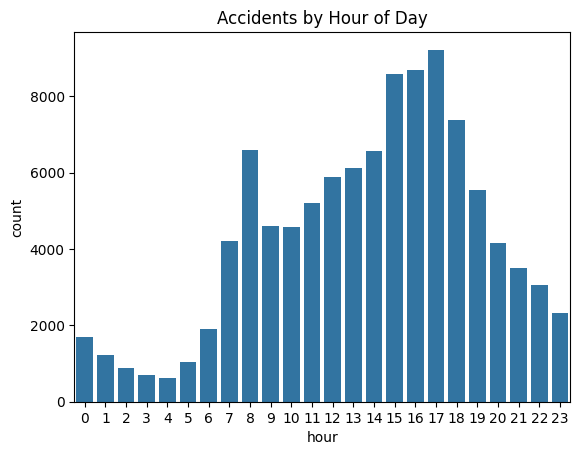

In [33]:
data['hour'] = pd.to_datetime(data['time'], errors='coerce').dt.hour
sns.countplot(x='hour', data=data)
plt.title("Accidents by Hour of Day")

Text(0.5, 1.0, 'Accidents by Day of Week')

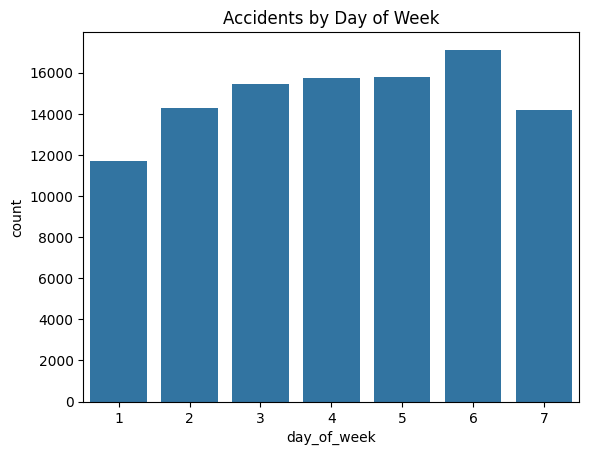

In [34]:
sns.countplot(x='day_of_week', data=data)
plt.title("Accidents by Day of Week")

Text(0.5, 1.0, 'Accidents per Month')

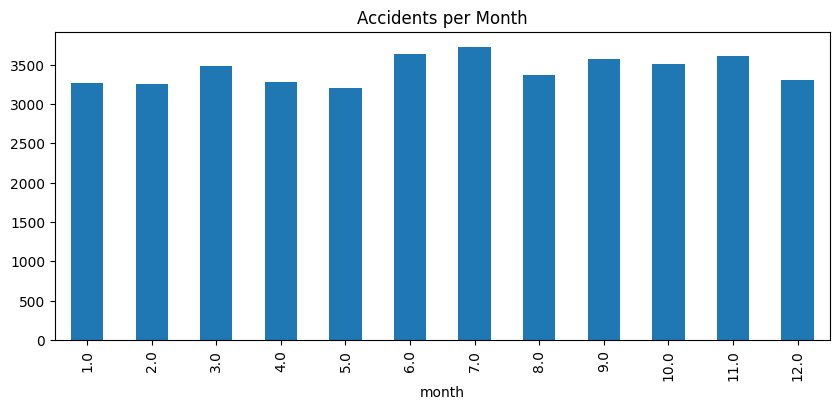

In [35]:
monthly = data['month'].value_counts().sort_index()
monthly.plot(kind='bar', figsize=(10,4))
plt.title("Accidents per Month")

In [36]:
import folium
from folium.plugins import HeatMap
m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=6)
HeatMap(data[['latitude','longitude']].dropna()).add_to(m)
m

Text(0.5, 1.0, 'Accidents by Weather')

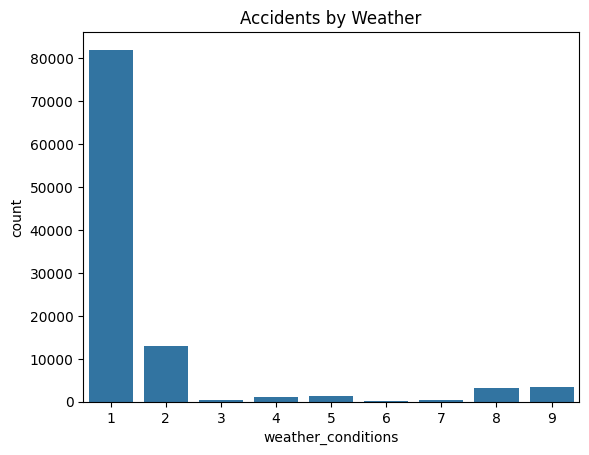

In [37]:
sns.countplot(x='weather_conditions', data=data)
plt.title("Accidents by Weather")

In [38]:
# Robust Time Conversion
print("Converting time column from 'HH:MM' format...")

# Convert the column to datetime, specifying the exact format
df['accident_time'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce')

# Time Engineering
print("Creating time-based features...")
# Extract components
df['hour'] = df['accident_time'].dt.hour
df['minute'] = df['accident_time'].dt.minute

# Create cyclical time features (CRITICAL for models to understand 23:00 is close to 00:00)
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

# Create interpretable binary features
df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9)) | ((df['hour'] >= 16) & (df['hour'] <= 18))
df['is_night'] = (df['hour'] >= 19) | (df['hour'] <= 6) # Simple definition of night

# May not need the original 'time' and 'accident_time' column for modeling and consider dropping.
df = df.drop(columns=['time', 'accident_time'])

#verify the new features
print(df[['hour', 'hour_sin', 'hour_cos', 'is_rush_hour', 'is_night']].tail())

Converting time column from 'HH:MM' format...
Creating time-based features...
        hour  hour_sin  hour_cos  is_rush_hour  is_night
104253     8  0.866025 -0.500000          True     False
104254    10  0.500000 -0.866025         False     False
104255    17 -0.965926 -0.258819          True     False
104256    21 -0.707107  0.707107         False      True
104257    16 -0.866025 -0.500000          True     False


----------------------------------------------------------------
**<ins>Explanation**

The raw time of each accident (e.g., 01:24) was transformed into more meaningful features:
- **Cyclical Encoding** (hour_sin, hour_cos): Transforms the hour into coordinates on a 24-hour circle so the model understands that times like 11 PM and 1 AM are close together.
- **Binary Indicators** (is_night, is_rush_hour): Provides the model with direct, high-level context using domain knowledge (e.g., accidents at night are often more severe).

-----------------------------------------------------------------

In [39]:
# Separating the numerical variables from the categorical variables
cat_col=df.select_dtypes(include=[object])
num_col = df.select_dtypes(include=['float','int'])

print(f"Categorical:\n {cat_col.columns}")
print(f"Numerical:\n {num_col.columns}")

Categorical:
 Index(['local_authority_ons_district', 'local_authority_highway',
       'lsoa_of_accident_location'],
      dtype='object')
Numerical:
 Index(['police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'first_road_class',
       'first_road_number', 'road_type', 'speed_limit', 'junction_detail',
       'junction_control', 'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'month', 'day', 'hour', 'weekday', 'is_weekend',
       'region_cluster', 'minute', 'hour_sin', 'hour_cos'],
      dtype='object')


In [40]:
# Handle missing values: fill with mode for categorical, median for numeric
# Fill numeric columns with mode
# for col in num_col.columns:
#     df[col] = df[col].fillna(df[col].mode())

# Fill categorical columns with mode
for col in cat_col.columns:
    df[col] = df[col].fillna(df[col].mode()[0])


In [41]:
df.head()

police_force  accident_severity  number_of_vehicles  number_of_casualties  \
0             1                  3                   1                     1   
1             1                  3                   3                     2   
2             1                  3                   2                     1   
3             1                  3                   2                     1   
4             1                  3                   2                     1   

   day_of_week local_authority_ons_district local_authority_highway  \
0            1                    E09000024               E09000024   
1            1                    E09000010               E09000010   
2            1                    E09000017               E09000017   
3            1                    E09000003               E09000003   
4            1                    E09000032               E09000032   

   first_road_class  first_road_number  road_type  ...  day  hour  weekday  \
0                 5                  0          2  ...  1.0     1      6.0   
1                 6                  0          6  ...  1.0     2      6.0   
2                 3                437          1  ...  1.0     3      6.0   
3                 3                  5          6  ...  1.0     2      6.0   
4                 3               3220          6  ...  1.0     1      6.0   

   is_weekend  region_cluster  minute  hour_sin  hour_cos  is_rush_hour  \
0           1             1.0      24  0.258819  0.965926         False   
1           1             1.0      25  0.500000  0.866025         False   
2           1             1.0      50  0.707107  0.707107         False   
3           1             1.0      13  0.500000  0.866025         False   
4           1             1.0      42  0.258819  0.965926         False   

   is_night  
0      True  
1      True  
2      True  
3      True  
4      True  

[5 rows x 37 columns]

In [42]:
df.isnull().sum()

police_force                                       0
accident_severity                                  0
number_of_vehicles                                 0
number_of_casualties                               0
day_of_week                                        0
local_authority_ons_district                       0
local_authority_highway                            0
first_road_class                                   0
first_road_number                                  0
road_type                                          0
speed_limit                                        0
junction_detail                                    0
junction_control                                   0
second_road_class                                  0
second_road_number                                 0
pedestrian_crossing_human_control                  0
pedestrian_crossing_physical_facilities            0
light_conditions                                   0
weather_conditions                            

In [43]:
df.dtypes

police_force                                     int64
accident_severity                                int64
number_of_vehicles                               int64
number_of_casualties                             int64
day_of_week                                      int64
local_authority_ons_district                    object
local_authority_highway                         object
first_road_class                                 int64
first_road_number                                int64
road_type                                        int64
speed_limit                                      int64
junction_detail                                  int64
junction_control                                 int64
second_road_class                                int64
second_road_number                               int64
pedestrian_crossing_human_control                int64
pedestrian_crossing_physical_facilities          int64
light_conditions                                 int64
weather_co

In [44]:
df.head()

police_force  accident_severity  number_of_vehicles  number_of_casualties  \
0             1                  3                   1                     1   
1             1                  3                   3                     2   
2             1                  3                   2                     1   
3             1                  3                   2                     1   
4             1                  3                   2                     1   

   day_of_week local_authority_ons_district local_authority_highway  \
0            1                    E09000024               E09000024   
1            1                    E09000010               E09000010   
2            1                    E09000017               E09000017   
3            1                    E09000003               E09000003   
4            1                    E09000032               E09000032   

   first_road_class  first_road_number  road_type  ...  day  hour  weekday  \
0                 5                  0          2  ...  1.0     1      6.0   
1                 6                  0          6  ...  1.0     2      6.0   
2                 3                437          1  ...  1.0     3      6.0   
3                 3                  5          6  ...  1.0     2      6.0   
4                 3               3220          6  ...  1.0     1      6.0   

   is_weekend  region_cluster  minute  hour_sin  hour_cos  is_rush_hour  \
0           1             1.0      24  0.258819  0.965926         False   
1           1             1.0      25  0.500000  0.866025         False   
2           1             1.0      50  0.707107  0.707107         False   
3           1             1.0      13  0.500000  0.866025         False   
4           1             1.0      42  0.258819  0.965926         False   

   is_night  
0      True  
1      True  
2      True  
3      True  
4      True  

[5 rows x 37 columns]

In [45]:
cat_var.columns

Index(['accident_index', 'accident_reference', 'date', 'time',
       'local_authority_ons_district', 'local_authority_highway',
       'lsoa_of_accident_location'],
      dtype='object')

In [46]:
cat_col.columns

Index(['local_authority_ons_district', 'local_authority_highway',
       'lsoa_of_accident_location'],
      dtype='object')

In [47]:
df.head()

police_force  accident_severity  number_of_vehicles  number_of_casualties  \
0             1                  3                   1                     1   
1             1                  3                   3                     2   
2             1                  3                   2                     1   
3             1                  3                   2                     1   
4             1                  3                   2                     1   

   day_of_week local_authority_ons_district local_authority_highway  \
0            1                    E09000024               E09000024   
1            1                    E09000010               E09000010   
2            1                    E09000017               E09000017   
3            1                    E09000003               E09000003   
4            1                    E09000032               E09000032   

   first_road_class  first_road_number  road_type  ...  day  hour  weekday  \
0                 5                  0          2  ...  1.0     1      6.0   
1                 6                  0          6  ...  1.0     2      6.0   
2                 3                437          1  ...  1.0     3      6.0   
3                 3                  5          6  ...  1.0     2      6.0   
4                 3               3220          6  ...  1.0     1      6.0   

   is_weekend  region_cluster  minute  hour_sin  hour_cos  is_rush_hour  \
0           1             1.0      24  0.258819  0.965926         False   
1           1             1.0      25  0.500000  0.866025         False   
2           1             1.0      50  0.707107  0.707107         False   
3           1             1.0      13  0.500000  0.866025         False   
4           1             1.0      42  0.258819  0.965926         False   

   is_night  
0      True  
1      True  
2      True  
3      True  
4      True  

[5 rows x 37 columns]

In [48]:
# Columns to inspect
categorical_cols = [
    "day_of_week", "road_type", "junction_detail", "junction_control",
    "pedestrian_crossing_human_control", "pedestrian_crossing_physical_facilities",
    "light_conditions", "weather_conditions", "road_surface_conditions",
    "special_conditions_at_site", "carriageway_hazards",
    "urban_or_rural_area", "did_police_officer_attend_scene_of_accident",
    "trunk_road_flag"
]

# Extract unique values for each categorical column
encoded_values = {col: df[col].unique() for col in categorical_cols}
encoded_values


{'day_of_week': array([1, 2, 3, 4, 5, 6, 7]),
 'road_type': array([2, 6, 1, 3, 9, 7]),
 'junction_detail': array([ 9,  3,  1,  8,  0,  6,  2,  7, 99,  5, -1]),
 'junction_control': array([ 4, -1,  2,  9,  1,  3]),
 'pedestrian_crossing_human_control': array([ 2,  0,  1,  9, -1]),
 'pedestrian_crossing_physical_facilities': array([ 5,  1,  0,  4,  9,  8,  7, -1]),
 'light_conditions': array([4, 1, 6, 5, 7]),
 'weather_conditions': array([8, 1, 9, 2, 5, 4, 3, 7, 6]),
 'road_surface_conditions': array([ 2,  1,  9,  4,  3,  5, -1]),
 'special_conditions_at_site': array([ 0,  9,  4,  7,  3,  1,  2,  5,  6, -1]),
 'carriageway_hazards': array([ 0,  2,  9,  7,  1,  6,  3, -1]),
 'urban_or_rural_area': array([ 1,  2, -1,  3]),
 'did_police_officer_attend_scene_of_accident': array([1, 3, 2]),
 'trunk_road_flag': array([ 2,  1, -1])}

In [49]:
df.head()

police_force  accident_severity  number_of_vehicles  number_of_casualties  \
0             1                  3                   1                     1   
1             1                  3                   3                     2   
2             1                  3                   2                     1   
3             1                  3                   2                     1   
4             1                  3                   2                     1   

   day_of_week local_authority_ons_district local_authority_highway  \
0            1                    E09000024               E09000024   
1            1                    E09000010               E09000010   
2            1                    E09000017               E09000017   
3            1                    E09000003               E09000003   
4            1                    E09000032               E09000032   

   first_road_class  first_road_number  road_type  ...  day  hour  weekday  \
0                 5                  0          2  ...  1.0     1      6.0   
1                 6                  0          6  ...  1.0     2      6.0   
2                 3                437          1  ...  1.0     3      6.0   
3                 3                  5          6  ...  1.0     2      6.0   
4                 3               3220          6  ...  1.0     1      6.0   

   is_weekend  region_cluster  minute  hour_sin  hour_cos  is_rush_hour  \
0           1             1.0      24  0.258819  0.965926         False   
1           1             1.0      25  0.500000  0.866025         False   
2           1             1.0      50  0.707107  0.707107         False   
3           1             1.0      13  0.500000  0.866025         False   
4           1             1.0      42  0.258819  0.965926         False   

   is_night  
0      True  
1      True  
2      True  
3      True  
4      True  

[5 rows x 37 columns]

In [50]:
df.columns.tolist()

['police_force',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'day_of_week',
 'local_authority_ons_district',
 'local_authority_highway',
 'first_road_class',
 'first_road_number',
 'road_type',
 'speed_limit',
 'junction_detail',
 'junction_control',
 'second_road_class',
 'second_road_number',
 'pedestrian_crossing_human_control',
 'pedestrian_crossing_physical_facilities',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'special_conditions_at_site',
 'carriageway_hazards',
 'urban_or_rural_area',
 'did_police_officer_attend_scene_of_accident',
 'trunk_road_flag',
 'lsoa_of_accident_location',
 'month',
 'day',
 'hour',
 'weekday',
 'is_weekend',
 'region_cluster',
 'minute',
 'hour_sin',
 'hour_cos',
 'is_rush_hour',
 'is_night']

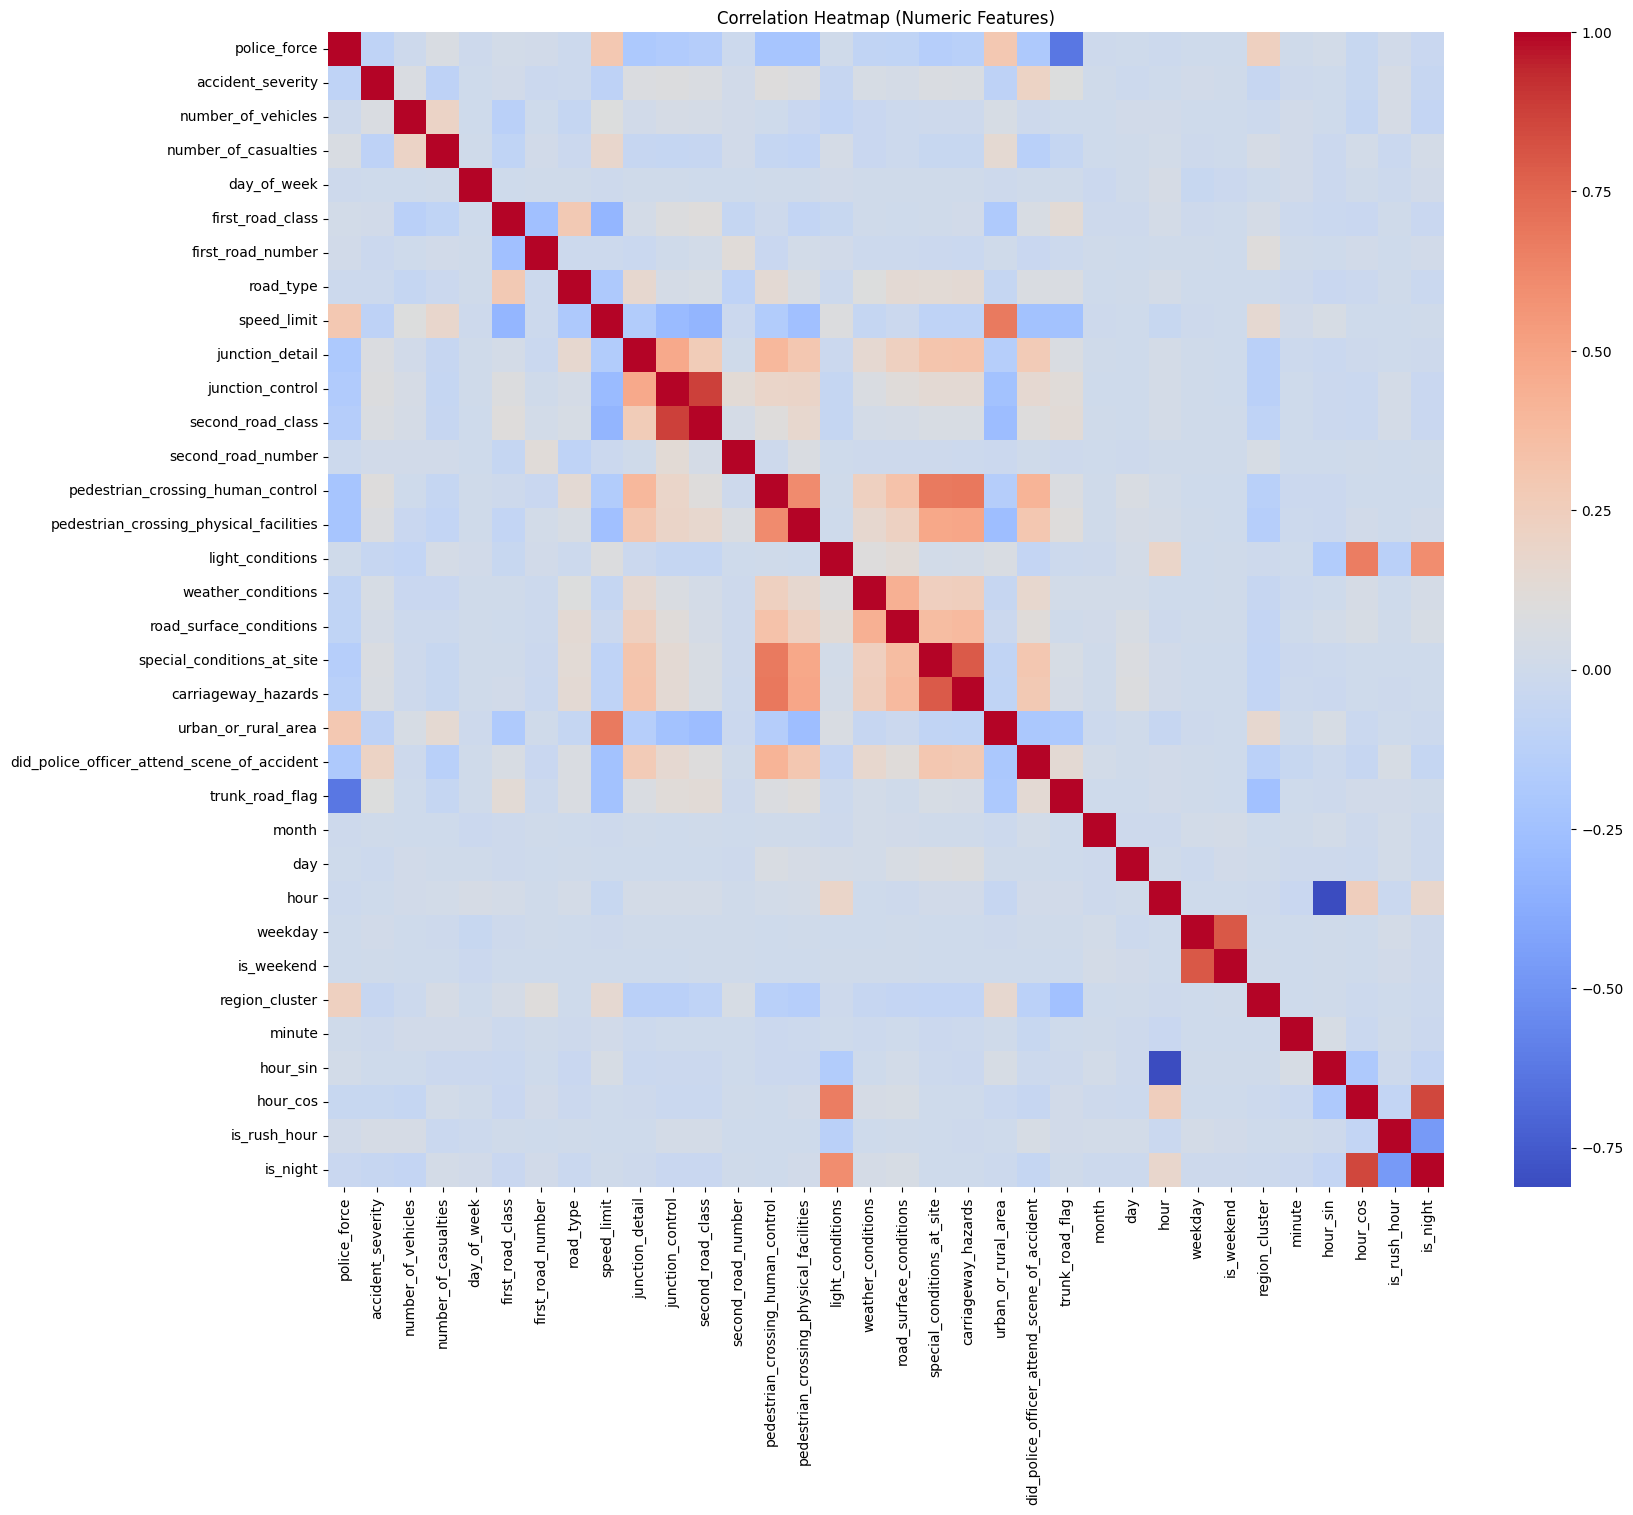

In [51]:
# Correlation matrix (numeric only)
plt.figure(figsize=(18,15))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

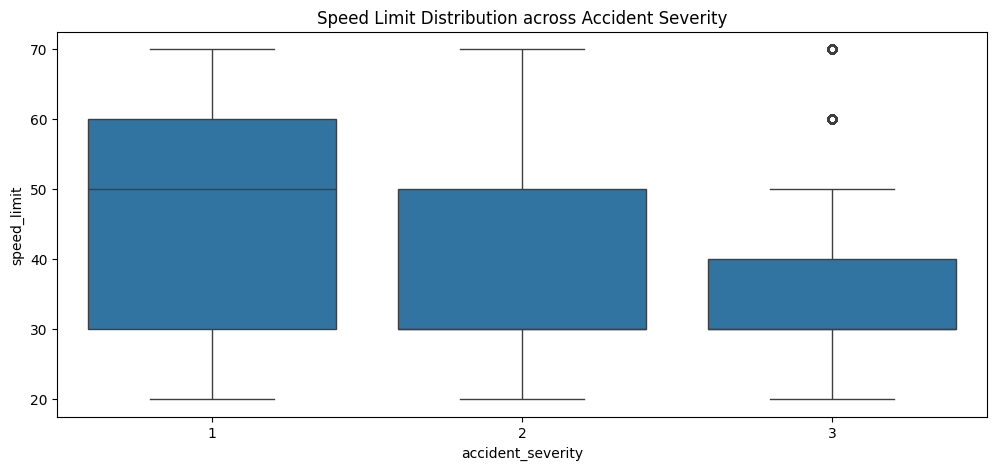

In [52]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="accident_severity", y="speed_limit", data=df)
plt.title("Speed Limit Distribution across Accident Severity")
plt.show()

In [53]:
df.columns.tolist()

['police_force',
 'accident_severity',
 'number_of_vehicles',
 'number_of_casualties',
 'day_of_week',
 'local_authority_ons_district',
 'local_authority_highway',
 'first_road_class',
 'first_road_number',
 'road_type',
 'speed_limit',
 'junction_detail',
 'junction_control',
 'second_road_class',
 'second_road_number',
 'pedestrian_crossing_human_control',
 'pedestrian_crossing_physical_facilities',
 'light_conditions',
 'weather_conditions',
 'road_surface_conditions',
 'special_conditions_at_site',
 'carriageway_hazards',
 'urban_or_rural_area',
 'did_police_officer_attend_scene_of_accident',
 'trunk_road_flag',
 'lsoa_of_accident_location',
 'month',
 'day',
 'hour',
 'weekday',
 'is_weekend',
 'region_cluster',
 'minute',
 'hour_sin',
 'hour_cos',
 'is_rush_hour',
 'is_night']

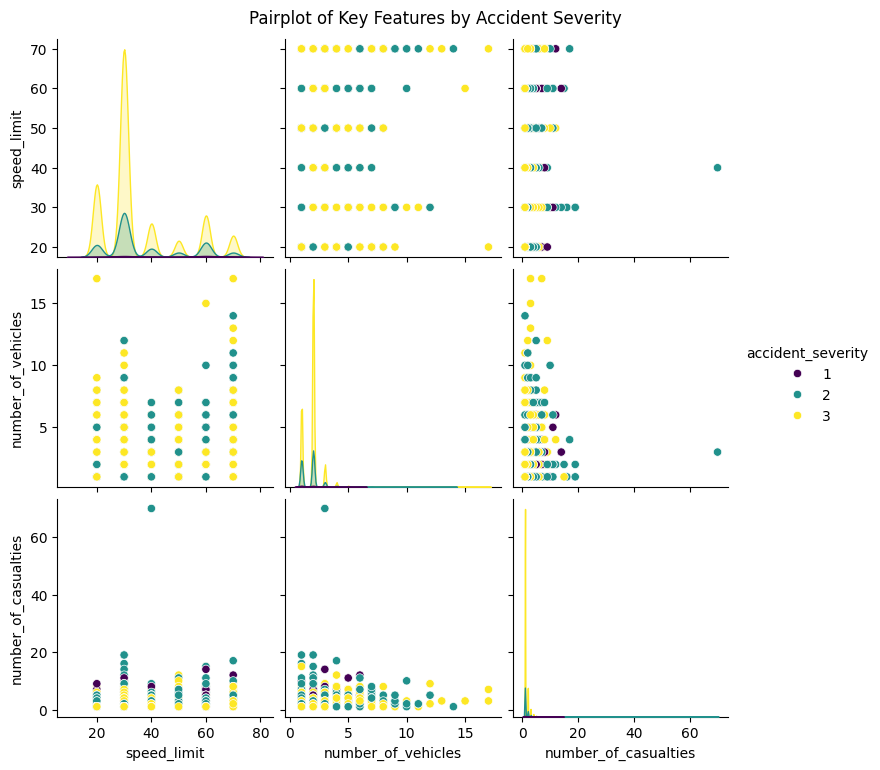

In [54]:
sns.pairplot(
    df[['speed_limit', 'number_of_vehicles', 'number_of_casualties', 'accident_severity']], 
    hue="accident_severity",
    diag_kind="kde",
    palette="viridis"
)
plt.suptitle("Pairplot of Key Features by Accident Severity", y=1.02)
plt.show()


In [55]:
# sns.pairplot(df,
#              diag_kind="kde",
#              palette="viridis")

In [56]:
# sns.pairplot(df)

In [57]:
df.describe()

police_force  accident_severity  number_of_vehicles  \
count  104258.000000      104258.000000       104258.000000   
mean       27.638397           2.745996            1.820628   
std        24.321077           0.467638            0.689053   
min         1.000000           1.000000            1.000000   
25%         4.000000           3.000000            1.000000   
50%        22.000000           3.000000            2.000000   
75%        45.000000           3.000000            2.000000   
max        99.000000           3.000000           17.000000   

       number_of_casualties    day_of_week  first_road_class  \
count         104258.000000  104258.000000     104258.000000   
mean               1.275461       4.129189          4.225565   
std                0.737006       1.929225          1.464022   
min                1.000000       1.000000          1.000000   
25%                1.000000       3.000000          3.000000   
50%                1.000000       4.000000          4.000000   
75%                1.000000       6.000000          6.000000   
max               70.000000       7.000000          6.000000   

       first_road_number      road_type    speed_limit  junction_detail  ...  \
count      104258.000000  104258.000000  104258.000000    104258.000000  ...   
mean          787.296054       5.294222      35.873602         4.632748  ...   
std          1578.472251       1.700894      14.349338        14.731899  ...   
min             0.000000       1.000000      20.000000        -1.000000  ...   
25%             0.000000       6.000000      30.000000         0.000000  ...   
50%            31.000000       6.000000      30.000000         3.000000  ...   
75%           539.000000       6.000000      40.000000         3.000000  ...   
max          9176.000000       9.000000      70.000000        99.000000  ...   

       trunk_road_flag         month           day           hour  \
count    104258.000000  41166.000000  41166.000000  104258.000000   
mean          1.721479      6.570592      6.741024      13.742466   
std           0.794875      3.421683      3.437485       5.190717   
min          -1.000000      1.000000      1.000000       0.000000   
25%           2.000000      4.000000      4.000000      10.000000   
50%           2.000000      7.000000      7.000000      15.000000   
75%           2.000000     10.000000     10.000000      17.000000   
max           2.000000     12.000000     12.000000      23.000000   

            weekday     is_weekend  region_cluster         minute  \
count  41166.000000  104258.000000   104246.000000  104258.000000   
mean       3.068843       0.118418        2.623563      26.813281   
std        2.010472       0.323104        2.211148      17.551646   
min        0.000000       0.000000        0.000000       0.000000   
25%        1.000000       0.000000        1.000000      11.000000   
50%        3.000000       0.000000        2.000000      28.000000   
75%        5.000000       0.000000        4.000000      42.000000   
max        6.000000       1.000000        7.000000      59.000000   

            hour_sin      hour_cos  
count  104258.000000  1.042580e+05  
mean       -0.258595 -3.001695e-01  
std         0.688889  6.070147e-01  
min        -1.000000 -1.000000e+00  
25%        -0.866025 -8.660254e-01  
50%        -0.500000 -5.000000e-01  
75%         0.258819  6.123234e-17  
max         1.000000  1.000000e+00  

[8 rows x 32 columns]

In [58]:
num_col.columns

Index(['police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'first_road_class',
       'first_road_number', 'road_type', 'speed_limit', 'junction_detail',
       'junction_control', 'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'month', 'day', 'hour', 'weekday', 'is_weekend',
       'region_cluster', 'minute', 'hour_sin', 'hour_cos'],
      dtype='object')

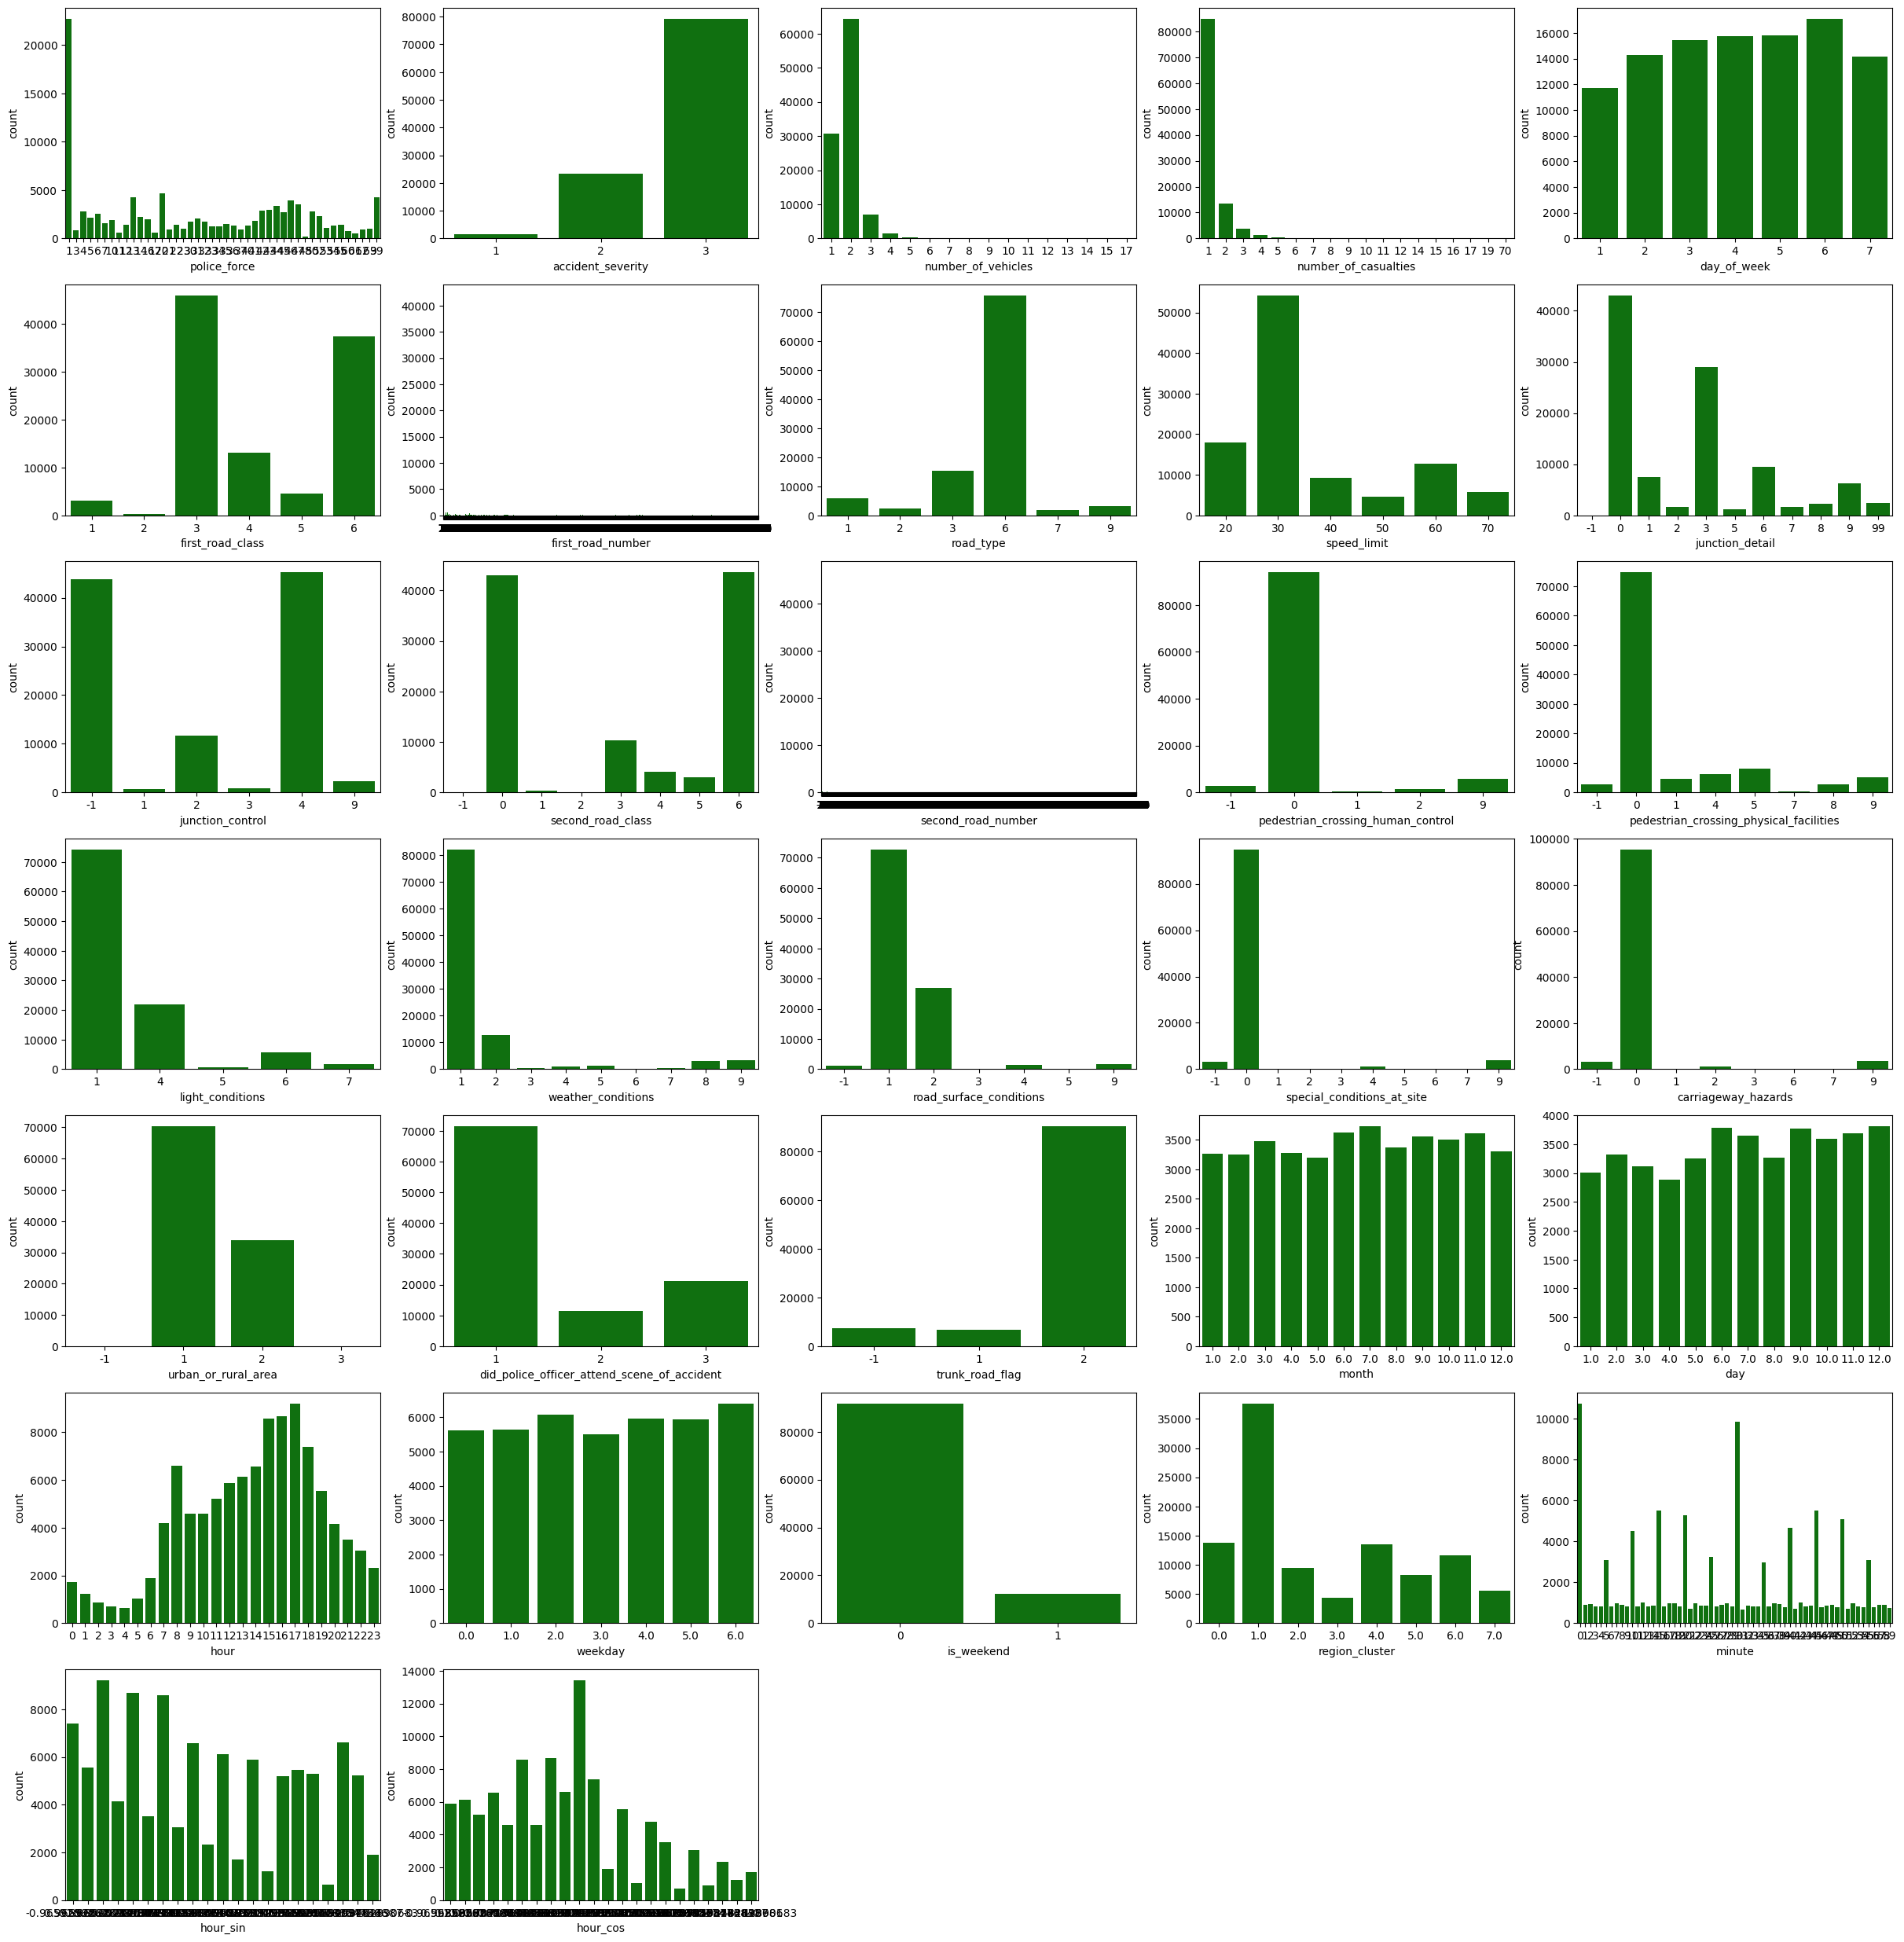

In [59]:
# plot the variables
fig = plt.figure(figsize=(30,45))
for i,j in zip(num_col,range(len(num_col.columns))):
    ax = fig.add_subplot(10,5, j+1)
    sns.countplot(data=df,x=df[i],color="Green")

In [60]:
# # EDA: Boxplots for features vs RiskLevel
# features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
# for feature in features:
#     plt.figure(figsize=(6,4))
#     sns.boxplot(x='accident_severity', y=feature, data=df)
#     plt.title(f"{feature} vs Accident Severity")
#     plt.show()

In [61]:
# sns.pairplot(df, 
#              kind='scatter', 
#              plot_kws={'alpha':0.4}, 
#              diag_kws={'alpha':0.55, 'bins':40})

In [62]:
# #Bivariate Data Analysis (Scatter Plots)
# comb = list(itertools.combinations([a for a in range(1, len(num_var.columns))], 2)) #Create combinations of all features, in twos (bivariate)
# rand = random.choices(comb, k=50) #Randomly choose 50 bivariate relationships to visualise.
# df['accident_severity'] = df['accident_severity'].astype('int') # Convert our tarrget variable to categorical because it is classification.

# fig = plt.figure(figsize=(20,25))
# for i in range(len(rand)):
#     ax = fig.add_subplot(10,5, i+1)
#     plt.scatter(num_var[num_var.columns[rand[i][0]]],num_var[num_var.columns[rand[i][1]]],c=df["accident_severity"])

In [63]:
data.columns

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location',
       'enhanced_severity_collision', 'month', 'day', 'hour'],
      dtype='object')

In [64]:
df.columns

Index(['police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location', 'month', 'day', 'hour',
       'weekday', 'is_weekend', 'region_cluster', 'minute', 'hour_sin',
       'hour_cos', 'is_rush_hour', 'is_night'],
      dtype='object')

In [65]:
# Check unique values for all object (categorical) columns
for col in df.select_dtypes(include="object"):
    print(f"{col}: {data[col].unique()}")
    print()

local_authority_ons_district: ['E09000024' 'E09000010' 'E09000017' 'E09000003' 'E09000032' 'E09000007'
 'E09000028' 'E09000025' 'E09000014' 'E09000018' 'E09000012' 'E09000019'
 'E09000026' 'E09000031' 'E09000022' 'E09000023' 'E09000033' 'E09000005'
 'E09000020' 'E09000004' 'E09000009' 'E09000016' 'E09000002' 'E09000030'
 'E09000015' 'E09000008' 'E09000027' 'E09000029' 'E09000013' 'E09000021'
 'E09000006' 'E09000011' 'EHEATHROW' 'E06000064' 'E06000063' 'E06000008'
 'E07000123' 'E07000128' 'E06000009' 'E07000122' 'E07000118' 'E07000121'
 'E07000125' 'E07000127' 'E07000119' 'E07000124' 'E07000120' 'E07000117'
 'E07000126' 'E08000015' 'E08000013' 'E08000012' 'E08000011' 'E08000014'
 'E08000007' 'E08000006' 'E08000010' 'E08000004' 'E08000009' 'E08000001'
 'E08000005' 'E08000002' 'E08000003' 'E08000008' 'E06000007' 'E06000049'
 'E06000050' 'E06000006' 'E06000057' 'E08000023' 'E08000021' 'E08000037'
 'E08000024' 'E08000022' 'E06000047' 'E06000005' 'E06000065' 'E06000014'
 'E08000032' 'E080000

In [66]:
# #plotting
# df['accident_severity'].value_counts().plot(kind = "bar", figsize = (10,4),color='Green')
# plt.title("Ratio of the Target Values")

In [67]:
df.head()

police_force  accident_severity  number_of_vehicles  number_of_casualties  \
0             1                  3                   1                     1   
1             1                  3                   3                     2   
2             1                  3                   2                     1   
3             1                  3                   2                     1   
4             1                  3                   2                     1   

   day_of_week local_authority_ons_district local_authority_highway  \
0            1                    E09000024               E09000024   
1            1                    E09000010               E09000010   
2            1                    E09000017               E09000017   
3            1                    E09000003               E09000003   
4            1                    E09000032               E09000032   

   first_road_class  first_road_number  road_type  ...  day  hour  weekday  \
0                 5                  0          2  ...  1.0     1      6.0   
1                 6                  0          6  ...  1.0     2      6.0   
2                 3                437          1  ...  1.0     3      6.0   
3                 3                  5          6  ...  1.0     2      6.0   
4                 3               3220          6  ...  1.0     1      6.0   

   is_weekend  region_cluster  minute  hour_sin  hour_cos  is_rush_hour  \
0           1             1.0      24  0.258819  0.965926         False   
1           1             1.0      25  0.500000  0.866025         False   
2           1             1.0      50  0.707107  0.707107         False   
3           1             1.0      13  0.500000  0.866025         False   
4           1             1.0      42  0.258819  0.965926         False   

   is_night  
0      True  
1      True  
2      True  
3      True  
4      True  

[5 rows x 37 columns]

In [68]:
df.head()

police_force  accident_severity  number_of_vehicles  number_of_casualties  \
0             1                  3                   1                     1   
1             1                  3                   3                     2   
2             1                  3                   2                     1   
3             1                  3                   2                     1   
4             1                  3                   2                     1   

   day_of_week local_authority_ons_district local_authority_highway  \
0            1                    E09000024               E09000024   
1            1                    E09000010               E09000010   
2            1                    E09000017               E09000017   
3            1                    E09000003               E09000003   
4            1                    E09000032               E09000032   

   first_road_class  first_road_number  road_type  ...  day  hour  weekday  \
0                 5                  0          2  ...  1.0     1      6.0   
1                 6                  0          6  ...  1.0     2      6.0   
2                 3                437          1  ...  1.0     3      6.0   
3                 3                  5          6  ...  1.0     2      6.0   
4                 3               3220          6  ...  1.0     1      6.0   

   is_weekend  region_cluster  minute  hour_sin  hour_cos  is_rush_hour  \
0           1             1.0      24  0.258819  0.965926         False   
1           1             1.0      25  0.500000  0.866025         False   
2           1             1.0      50  0.707107  0.707107         False   
3           1             1.0      13  0.500000  0.866025         False   
4           1             1.0      42  0.258819  0.965926         False   

   is_night  
0      True  
1      True  
2      True  
3      True  
4      True  

[5 rows x 37 columns]

In [69]:
df.columns

Index(['police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location', 'month', 'day', 'hour',
       'weekday', 'is_weekend', 'region_cluster', 'minute', 'hour_sin',
       'hour_cos', 'is_rush_hour', 'is_night'],
      dtype='object')

In [70]:
df_decoded

accident_index  accident_year accident_reference  \
0       2023010419171           2023          010419171   
1       2023010419183           2023          010419183   
2       2023010419189           2023          010419189   
3       2023010419191           2023          010419191   
4       2023010419192           2023          010419192   
...               ...            ...                ...   
104253  2023991452286           2023          991452286   
104254  2023991452640           2023          991452640   
104255  2023991453360           2023          991453360   
104256  2023991461915           2023          991461915   
104257  2023991462793           2023          991462793   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    525060.0                170416.0  -0.202878  51.418974   
1                    535463.0                198745.0  -0.042464  51.671155   
2                    508702.0                177696.0  -0.435789  51.487777   
3                    520341.0                190175.0  -0.263972  51.597575   
4                    527255.0                176963.0  -0.168976  51.477324   
...                       ...                     ...        ...        ...   
104253               246754.0                661133.0  -4.447490  55.819059   
104254               224491.0                581627.0  -4.752200  55.097920   
104255               383341.0                806427.0  -2.276957  57.148422   
104256               271662.0                655488.0  -4.047591  55.775637   
104257               327349.0                666746.0  -3.163102  55.888350   

        police_force  accident_severity  number_of_vehicles  ...  \
0                  1                  3                   1  ...   
1                  1                  3                   3  ...   
2                  1                  3                   2  ...   
3                  1                  3                   2  ...   
4                  1                  3                   2  ...   
...              ...                ...                 ...  ...   
104253            99                  2                   1  ...   
104254            99                  3                   2  ...   
104255            99                  3                   2  ...   
104256            99                  3                   1  ...   
104257            99                  3                   2  ...   

         road_type_decoded   pedestrian_crossing_human_decoded  \
0           One way street  Control by other authorised person   
1       Single carriageway               None within 50 metres   
2               Roundabout               None within 50 metres   
3       Single carriageway               None within 50 metres   
4       Single carriageway               None within 50 metres   
...                    ...                                 ...   
104253  Single carriageway                             Unknown   
104254  Single carriageway               None within 50 metres   
104255  Single carriageway                             Unknown   
104256  Single carriageway                             Unknown   
104257  Single carriageway               None within 50 metres   

               pedestrian_crossing_physical_decoded light_conditions_decoded  \
0       Pedestrian phase at traffic signal junction    Darkness - lights lit   
1                                    Zebra crossing    Darkness - lights lit   
2             No physical crossing within 50 metres    Darkness - lights lit   
3             No physical crossing within 50 metres    Darkness - lights lit   
4             No physical crossing within 50 metres    Darkness - lights lit   
...                                             ...                      ...   
104253                                      Unknown  Darkness - lights unlit   
104254        No physical crossing within 50 metres                 Daylight   
104255             

In [71]:
cat_col.columns

Index(['local_authority_ons_district', 'local_authority_highway',
       'lsoa_of_accident_location'],
      dtype='object')

In [72]:
df = df.drop(columns=cat_col, errors="ignore")

In [73]:
df.isnull().sum()

police_force                                       0
accident_severity                                  0
number_of_vehicles                                 0
number_of_casualties                               0
day_of_week                                        0
first_road_class                                   0
first_road_number                                  0
road_type                                          0
speed_limit                                        0
junction_detail                                    0
junction_control                                   0
second_road_class                                  0
second_road_number                                 0
pedestrian_crossing_human_control                  0
pedestrian_crossing_physical_facilities            0
light_conditions                                   0
weather_conditions                                 0
road_surface_conditions                            0
special_conditions_at_site                    

In [74]:
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

In [75]:
df.isnull().sum()

police_force                                   0
accident_severity                              0
number_of_vehicles                             0
number_of_casualties                           0
day_of_week                                    0
first_road_class                               0
first_road_number                              0
road_type                                      0
speed_limit                                    0
junction_detail                                0
junction_control                               0
second_road_class                              0
second_road_number                             0
pedestrian_crossing_human_control              0
pedestrian_crossing_physical_facilities        0
light_conditions                               0
weather_conditions                             0
road_surface_conditions                        0
special_conditions_at_site                     0
carriageway_hazards                            0
urban_or_rural_area 

In [76]:
# Features and target
X = df.drop("accident_severity", axis=1)
y = df["accident_severity"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [77]:
print("Before SMOTE, training target distribution:")
print(y_train.value_counts())

Before SMOTE, training target distribution:
accident_severity
3    63438
2    18750
1     1218
Name: count, dtype: int64


In [78]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [79]:
# # Standardize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [80]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# X_train_scaled = X_train.copy()
# X_test_scaled = X_test.copy()

# X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
# X_test_scaled[num_features] = scaler.transform(X_test[num_features])

### **Model Building**

In [81]:
X_train.isnull().sum()

police_force                                   0
number_of_vehicles                             0
number_of_casualties                           0
day_of_week                                    0
first_road_class                               0
first_road_number                              0
road_type                                      0
speed_limit                                    0
junction_detail                                0
junction_control                               0
second_road_class                              0
second_road_number                             0
pedestrian_crossing_human_control              0
pedestrian_crossing_physical_facilities        0
light_conditions                               0
weather_conditions                             0
road_surface_conditions                        0
special_conditions_at_site                     0
carriageway_hazards                            0
urban_or_rural_area                            0
did_police_officer_a

### **Handling Class Imbalance**

In [82]:
# Apply SMOTE on scaled training set
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_res.value_counts())

Before SMOTE:
 accident_severity
3    63438
2    18750
1     1218
Name: count, dtype: int64

After SMOTE:
 accident_severity
3    63438
2    63438
1    63438
Name: count, dtype: int64


In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [84]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

In [85]:
#Train models
def train_models(models, X_train_res, y_train_res):
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train_res, y_train_res)
        trained_models[name] = model
    return trained_models

In [86]:
#Evaluate
def evaluate_models(models, X_train_res, y_train_res, X_test, y_test):
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    for name, model in models.items():
        print(f"Model: {name}\n")
      
        # Predictions
        y_train_pred = model.predict(X_train_res)
        y_test_pred = model.predict(X_test)

        # Accuracy
        train_acc = accuracy_score(y_train_res, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        print(f"Train Accuracy: {train_acc:.2f}")
        print(f"Test Accuracy : {test_acc:.2f}")

        # Training set report
        print("\nClassification Report (Training Set):")
        print(classification_report(y_train_res, y_train_pred))

        # Test set report
        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred))

        # Confusion Matrix (test set only for clarity)
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {name} (Test Set)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


In [ ]:
# Train models on resampled training set
trained_models = train_models(models, X_train_res, y_train_res)

c:\Users\Yvonne\Desktop\DATA SCIENCE\machine_learning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Evaluate on training + test sets
evaluate_models(trained_models, X_train_res, y_train_res, X_test, y_test)

In [ ]:
# Train models on resampled training set
trained_models = train_models(models, X_train_res, y_train_res)

# Evaluate on training + test sets
evaluate_models(trained_models, X_train_res, y_train_res, X_test, y_test)

c:\Users\Yvonne\Desktop\DATA SCIENCE\machine_learning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# # Initialize models
# # models = {
# #     "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
# #     "Decision Tree": DecisionTreeClassifier(random_state=42),
# #     "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100)
# # }

# # Train and evaluate models
# results = {}
# for name, model in models.items():
#     model.fit(X_train_res, y_train_res)
#     y_pred = model.predict(X_test)
    
#     # Calculate metrics
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='weighted')
#     recall = recall_score(y_test, y_pred, average='weighted')
#     f1 = f1_score(y_test, y_pred, average='weighted')
    
#     results[name] = {
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1
#     }
    
#     print(f"{name} Performance:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")


c:\Users\Yvonne\Desktop\DATA SCIENCE\machine_learning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Yvonne\Desktop\DATA SCIENCE\machine_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Logistic Regression Performance:
Accuracy: 0.7605
Precision: 0.6731
Recall: 0.7605
F1-Score: 0.6613

Decision Tree Performance:
Accuracy: 0.6481
Precision: 0.6578
Recall: 0.6481
F1-Score: 0.6528

Random Forest Performance:
Accuracy: 0.7567
Precision: 0.6794
Recall: 0.7567
F1-Score: 0.6803


c:\Users\Yvonne\Desktop\DATA SCIENCE\machine_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### **Model Comparison**

Model Comparison:
                     accuracy  precision    recall        f1
Logistic Regression  0.760503   0.673102  0.760503  0.661293
Decision Tree        0.648139   0.657845  0.648139  0.652839
Random Forest        0.756714   0.679385  0.756714  0.680350


<Figure size 1000x600 with 0 Axes>

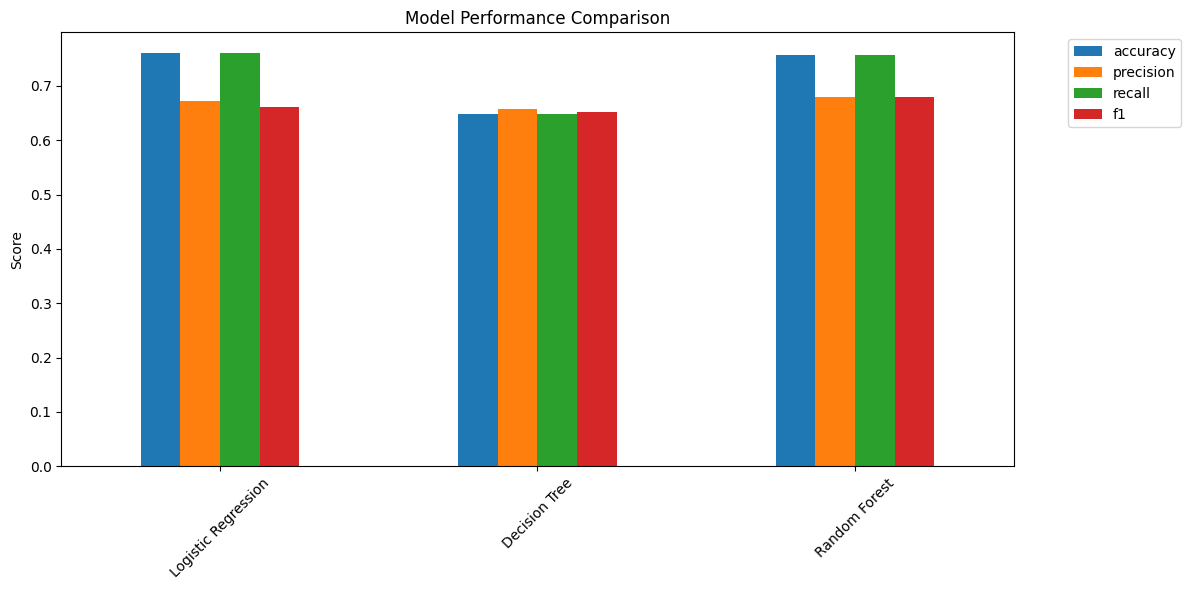

In [ ]:
# Create comparison dataframe
results_df = pd.DataFrame(results).T
print("Model Comparison:")
print(results_df)

# Plot performance comparison
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Hyperparameter Tuning**

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
print("Performing Grid Search for Random Forest...")
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Evaluate best model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best, average='weighted')

print(f"Tuned Random Forest Performance:")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"F1-Score: {best_f1:.4f}")

### **Feature Importance**

In [ ]:
# Get feature importances from best model
feature_importances = best_rf.feature_importances_
feature_names = X.columns

# Create dataframe for feature importances
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=fi_df.head(15))
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### **Confusion Matrix**

In [ ]:
# Plot confusion matrix for best model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Slight', 'Serious', 'Fatal'],
            yticklabels=['Slight', 'Serious', 'Fatal'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_best, 
                           target_names=['Slight', 'Serious', 'Fatal']))

### **Learning Curves**

In [ ]:
# from sklearn.model_selection import learning_curve

# def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1):
#     plt.figure(figsize=(10, 6))
#     plt.title(title)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
    
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, 
#         train_sizes=np.linspace(0.1, 1.0, 5),
#         scoring='accuracy'
#     )
    
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
    
#     plt.grid()
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
#     plt.legend(loc="best")
#     return plt

# # Plot learning curve for best model
# plot_learning_curve(best_rf, "Learning Curve (Random Forest)", 
#                    X_train, y_train, cv=5)
# plt.show()

### **Model Deployment Preparation**

In [ ]:

import joblib
import json

# Save the best model
joblib.dump(best_rf, 'road_accident_severity_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save label encoders
with open('label_encoders.json', 'w') as f:
    json.dump({col: list(le.classes_) for col, le in label_encoders.items()}, f)

print("\nModel and preprocessing objects saved successfully!")

#Prediction Function


def predict_accident_severity(new_data):
    """
    Predict accident severity for new data
    new_data: DataFrame with same columns as training data
    """
    # Load model and preprocessing objects
    model = joblib.load('road_accident_severity_model.pkl')
    scaler = joblib.load('scaler.pkl')
    
    # Preprocess new data
    new_data_processed = new_data.copy()
    
    # Handle missing values
    for col in new_data_processed.columns:
        if new_data_processed[col].dtype == "object":
            new_data_processed[col].fillna(df[col].mode()[0], inplace=True)
        else:
            new_data_processed[col].fillna(df[col].median(), inplace=True)
    
    # Encode categorical variables
    with open('label_encoders.json', 'r') as f:
        encoder_classes = json.load(f)
    
    for col in new_data_processed.select_dtypes(include=["object"]).columns:
        if col in encoder_classes:
            le = LabelEncoder()
            le.classes_ = np.array(encoder_classes[col])
            new_data_processed[col] = le.transform(new_data_processed[col])
    
    # Scale features
    new_data_scaled = scaler.transform(new_data_processed)
    
    # Make prediction
    predictions = model.predict(new_data_scaled)
    
    # Map predictions to severity labels
    severity_map = {0: 'Slight', 1: 'Serious', 2: 'Fatal'}
    predicted_severity = [severity_map[pred] for pred in predictions]
    
    return predicted_severity

# Example usage (commented out)
# sample_data = X_test.head(3).copy()
# predictions = predict_accident_severity(sample_data)
# print(f"Predictions: {predictions}")

In [ ]:
#Summary

print(f"Dataset shape: {df.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Target variable distribution:\n{y.value_counts()}")

print(f"\nBest model: Random Forest (Tuned)")
print(f"Best accuracy: {best_accuracy:.4f}")
print(f"Best F1-score: {best_f1:.4f}")

print("\nTop 5 most important features:")
for i, row in fi_df.head().iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

print("\nKey Insights:")
print("- Random Forest performed best among the tested models")
print("- Class imbalance is present and should be addressed")
print("- Feature importance analysis reveals the most influential factors")
print("- The model is ready for deployment and further optimization")

# Save final results
final_results = {
    'best_model': 'Random Forest',
    'best_params': grid_search.best_params_,
    'accuracy': best_accuracy,
    'f1_score': best_f1,
    'top_features': fi_df.head(10).to_dict()
}

with open('final_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

print("\nProject completed successfully! Results saved to final_results.json")

In [ ]:
# # Standardize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)